In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load the macro data
df = pd.read_csv('/data/sberbank/macro.csv',parse_dates=['timestamp'])
print(df.shape) #number of rowm, number of columns

(2484, 100)


# Data Types

In [3]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,datetime64[ns],1
1,int64,2
2,float64,94
3,object,3


Let's take a look at those non numerical columns

In [4]:
df.select_dtypes(include=['O']).dropna().head()

,child_on_acc_pre_school,modern_education_share,old_education_build_share
1096,"3,013","90,92","23,14"
1097,"3,013","90,92","23,14"
1098,"3,013","90,92","23,14"
1099,"3,013","90,92","23,14"
1100,"3,013","90,92","23,14"


These columns should also be numeric, we will replace "," with '.' for the processing.

In [5]:
for col in df.select_dtypes(include=['O']).columns.tolist():
    df[col] = df[col].apply(lambda s: str(s).replace(',','.')).apply(pd.to_numeric, errors='coerce')

# Missing Values

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


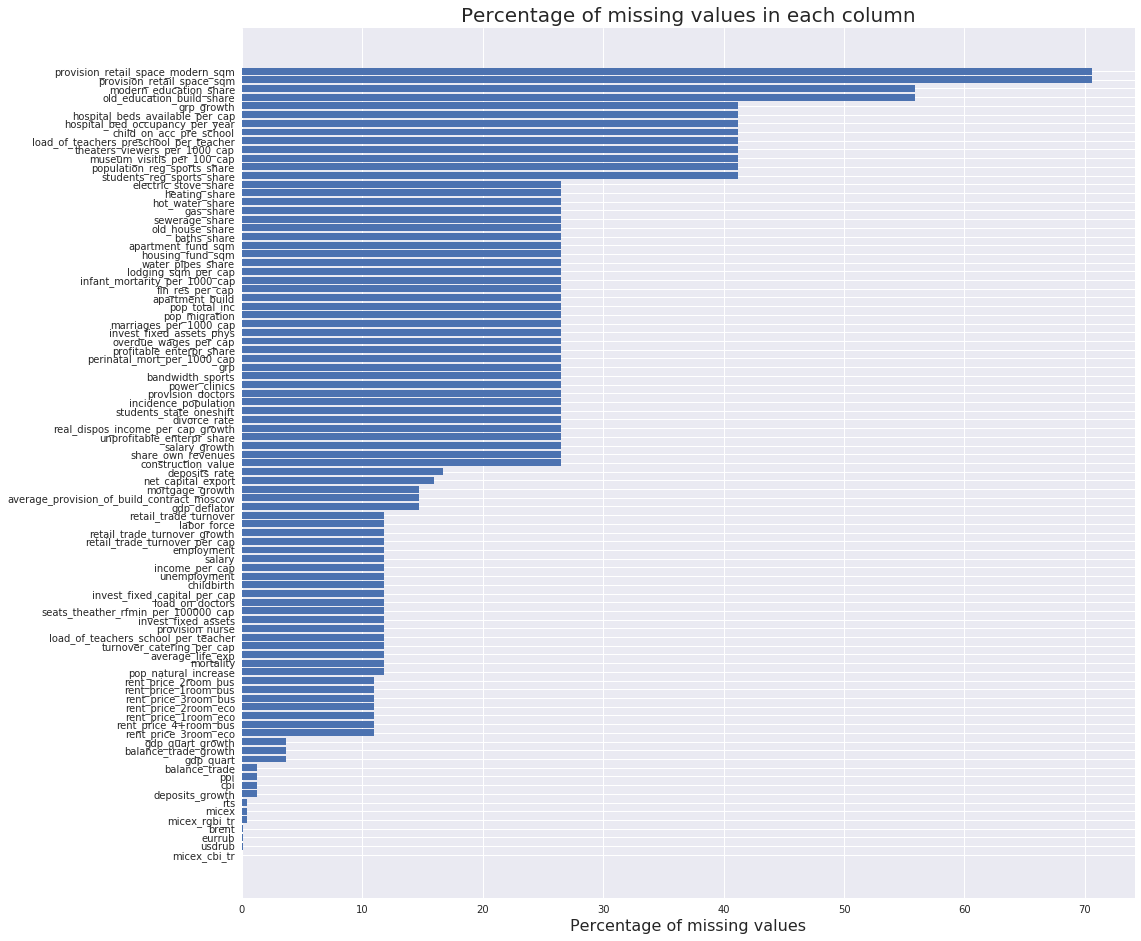

In [6]:
nan_df = pd.DataFrame(columns=['colname', 'cnt'])
nan_df['colname'] =  df.columns[df.isnull().any()].tolist() 
nan_df['cnt'] = nan_df.colname.apply( lambda x : df[x].isnull().sum(axis=0)/len(df)*100)
nan_df.sort_values(by='cnt', inplace = True)
f, ax = plt.subplots(figsize= (16,16))
idx = range(len(nan_df))
ax.barh( idx , nan_df.cnt.values )
ax.set_yticks(idx)
ax.set_yticklabels(nan_df.colname.values)
ax.set_title('Percentage of missing values in each column', fontsize = 20)
ax.set_xlabel("Percentage of missing values", fontsize = 16)
plt.show()

# The periods of the macro data 

In [7]:
cols = df.columns.tolist()
df_period = pd.DataFrame(index = cols, columns = ['period'])
for col in df.columns:
    df_cnt = df.ix[df.timestamp<=pd.to_datetime('2015-12-31'),col].value_counts().reset_index()[col].value_counts().reset_index()
    df_cnt.columns = ['period', 'counts']
    period = 'none'
    df_cnt = df_cnt.astype(int)

    if max(df_cnt.period)<28:
        period = 'daily'
    elif set(df_cnt.period).issubset(set([365,366,730,731,1096])):
        period = 'annual'
    elif set(df_cnt.period).issubset(set([90,91,92,182,181,182,183,184])):
        period = 'quarterly'
    elif set(df_cnt.period).issubset(set([28,29,30,31,60,61,62,90,91,92,93,123,152,153])):
        period = 'monthly'   
    elif set(df_cnt.period).issubset(set([1,28,29,30,31,60,61,62,90,91,92,93,123,152,153])):
        period = 'mostly monthly' # monthly with 1-day-violation each year， 
    df_period.ix[col, 'period'] = period 
    
df_period.period.value_counts()

annual            67
monthly           18
daily              8
quarterly          5
mostly monthly     2
Name: period, dtype: int64

##### Most of the macro data are annual and monthly.

# Plots 

In [8]:
# load the macro data and get the monthly median 
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['quarter'] = df.timestamp.dt.quarter
df['yearmonth'] = df['year'].apply(lambda x :'{0:04d}'.format( x))+ df['month'].apply(lambda x :'{0:02d}'.format( x))
df['yearquarter'] = df['year'].apply(lambda x :'{0:04d}'.format( x))+'Q'+ df['quarter'].apply(lambda x :'{0:01d}'.format( x))

### Columns with period = daily

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


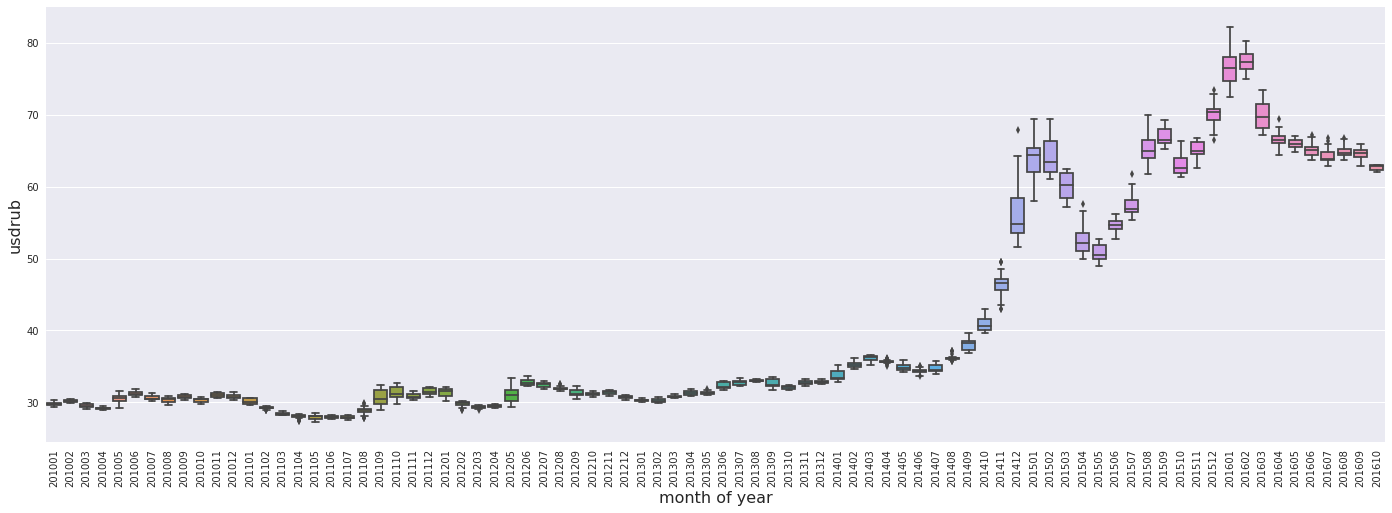

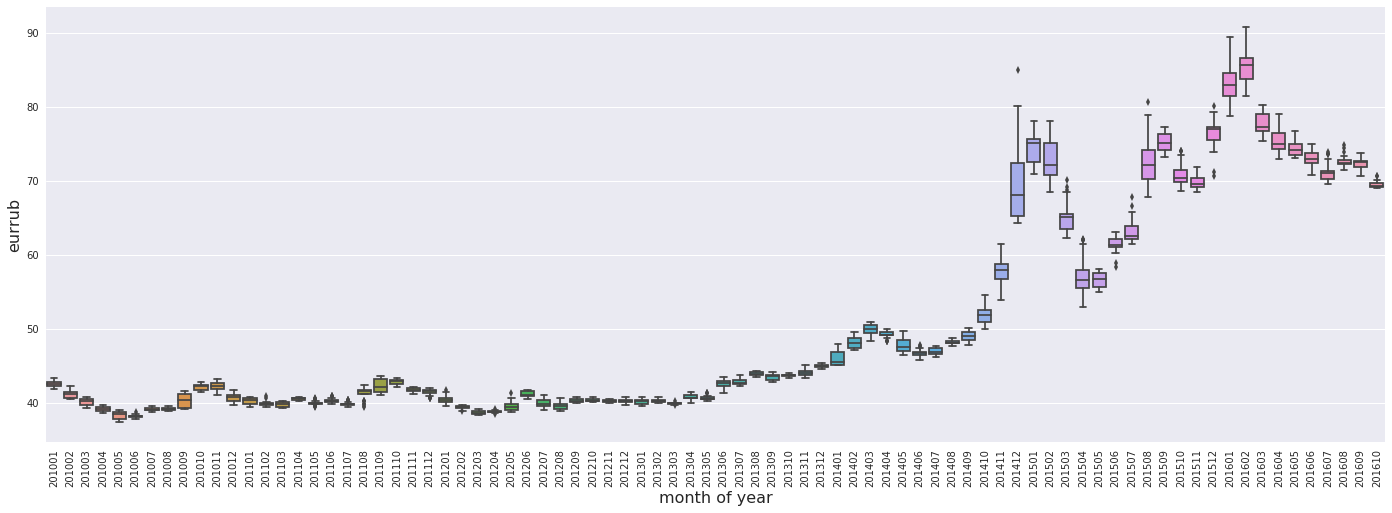

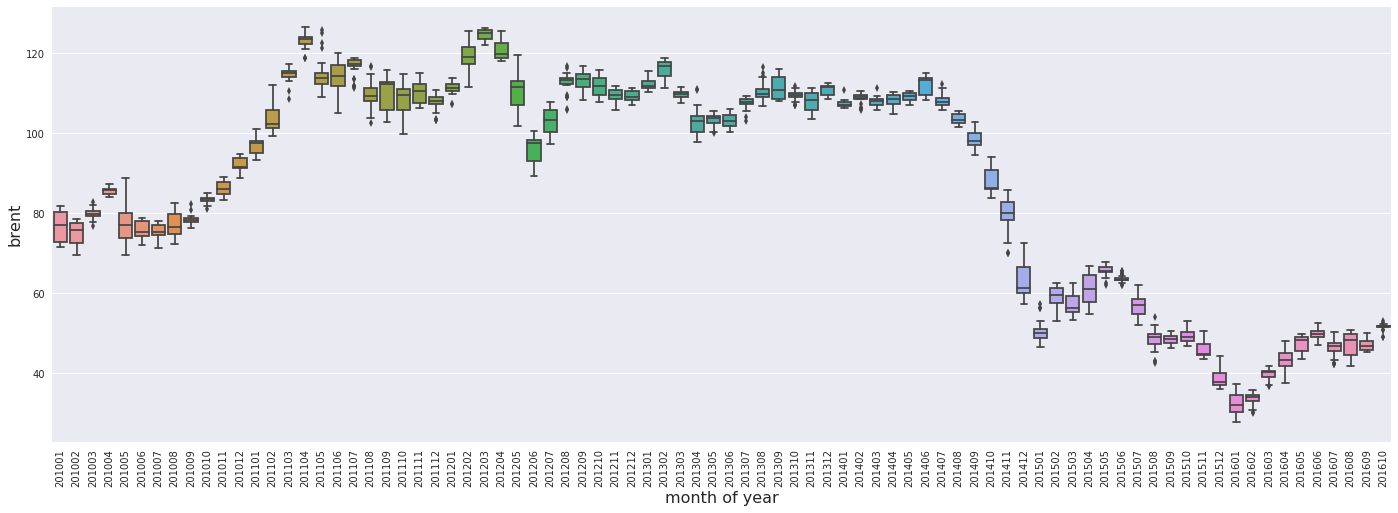

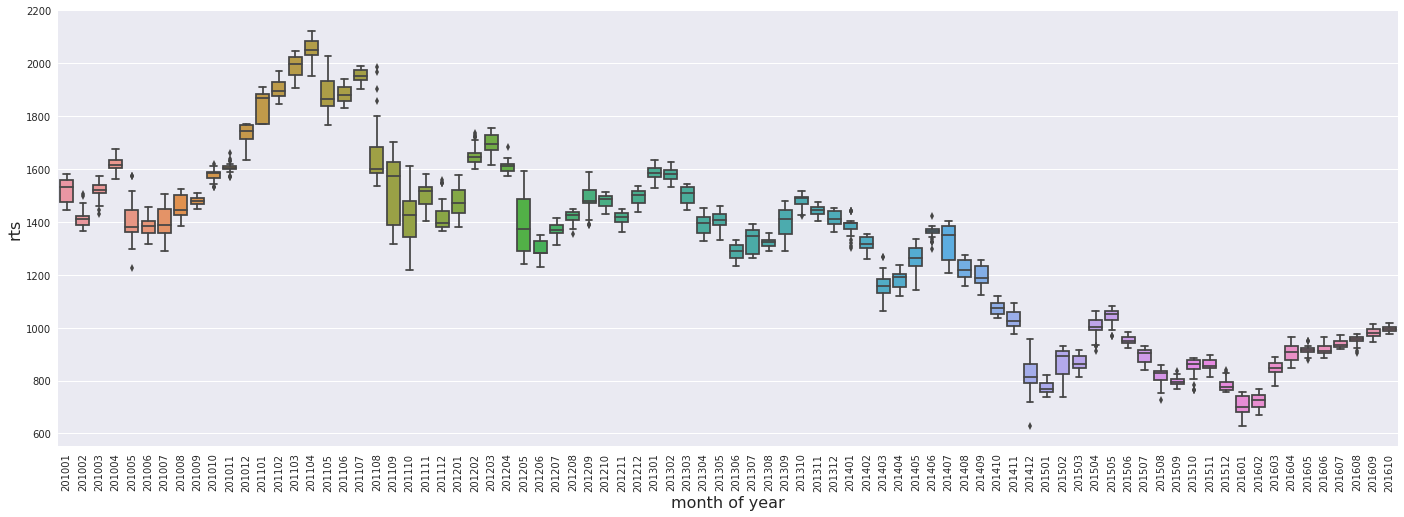

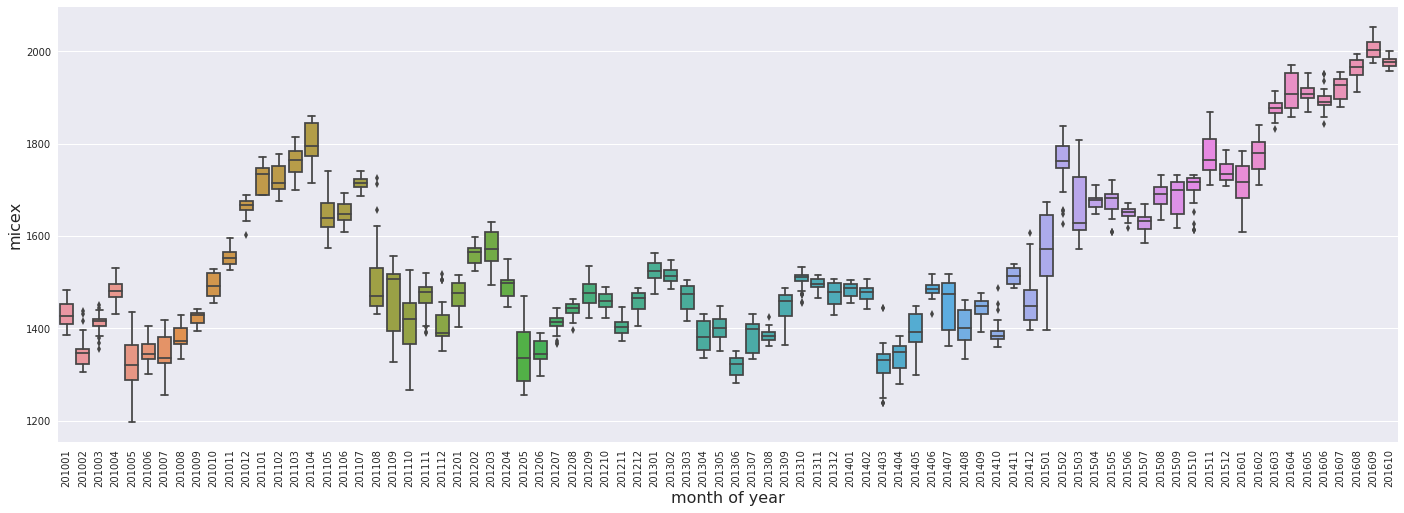

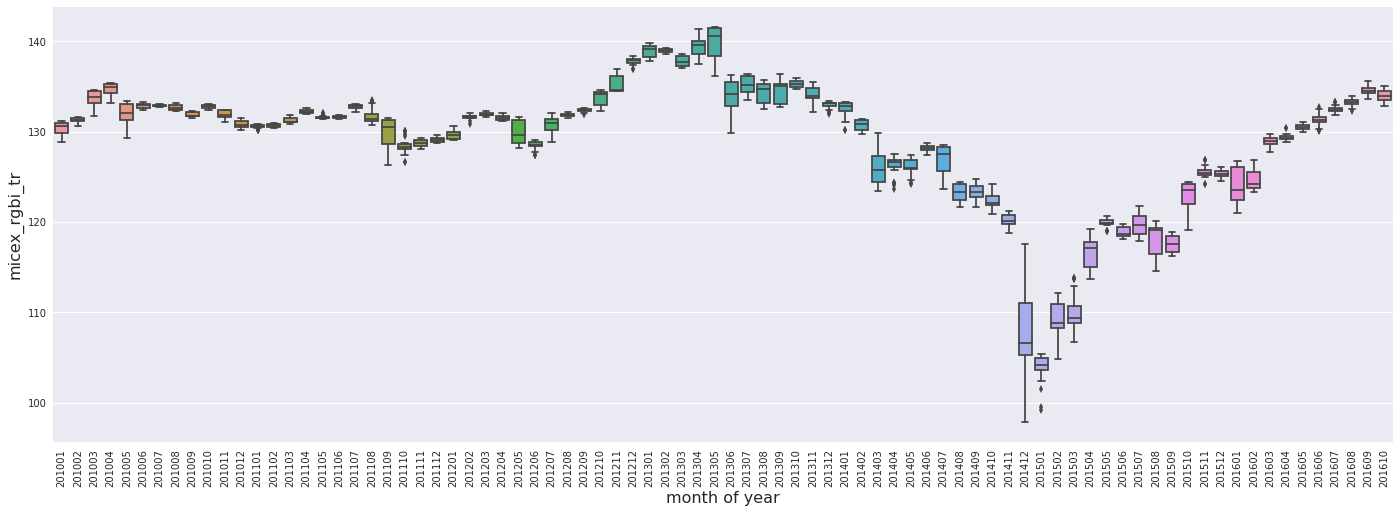

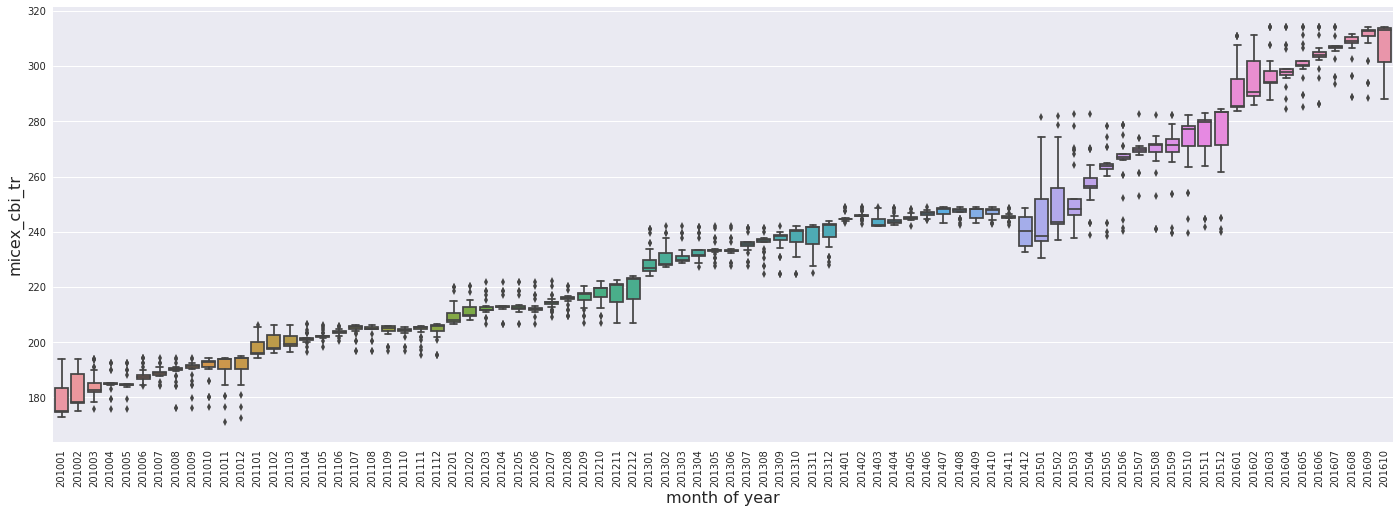

In [9]:
dailycol =  df_period.index[df_period['period'] == 'daily'][1:]
for col in dailycol:
    plt.figure(figsize=(24,8))
    sns.boxplot(x='yearmonth', y=col, data=df)
    plt.xlabel('month of year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


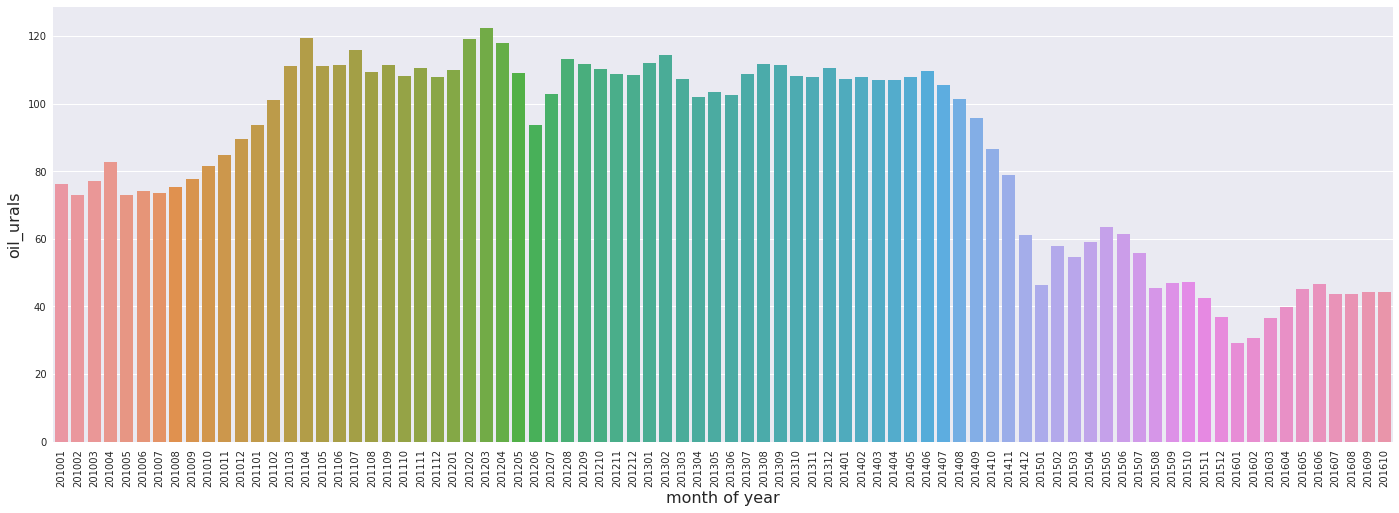

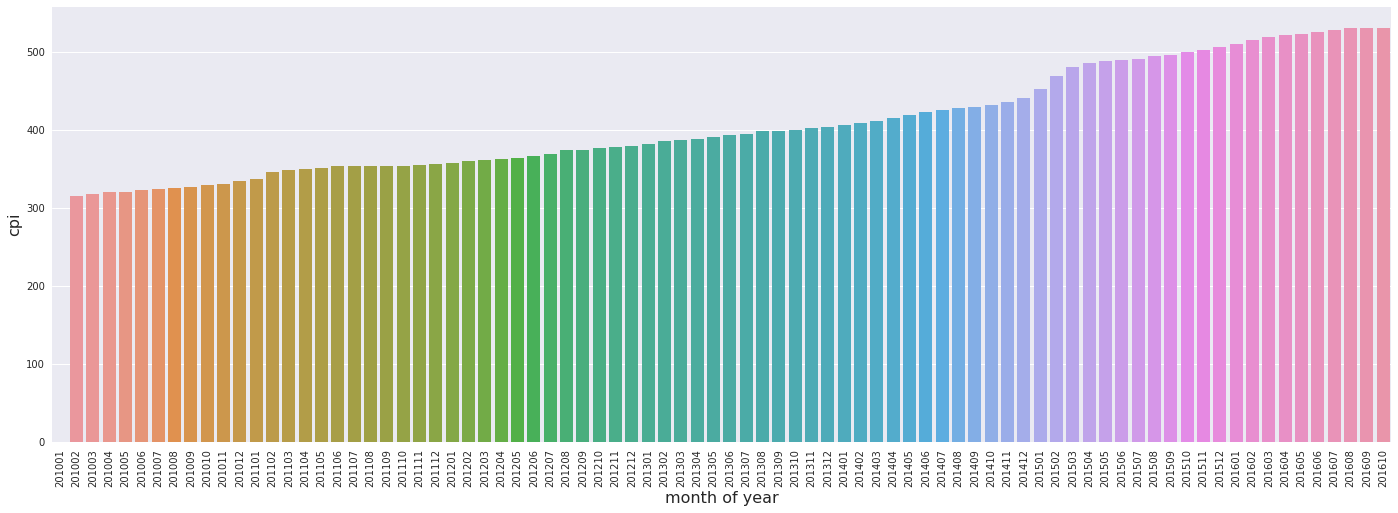

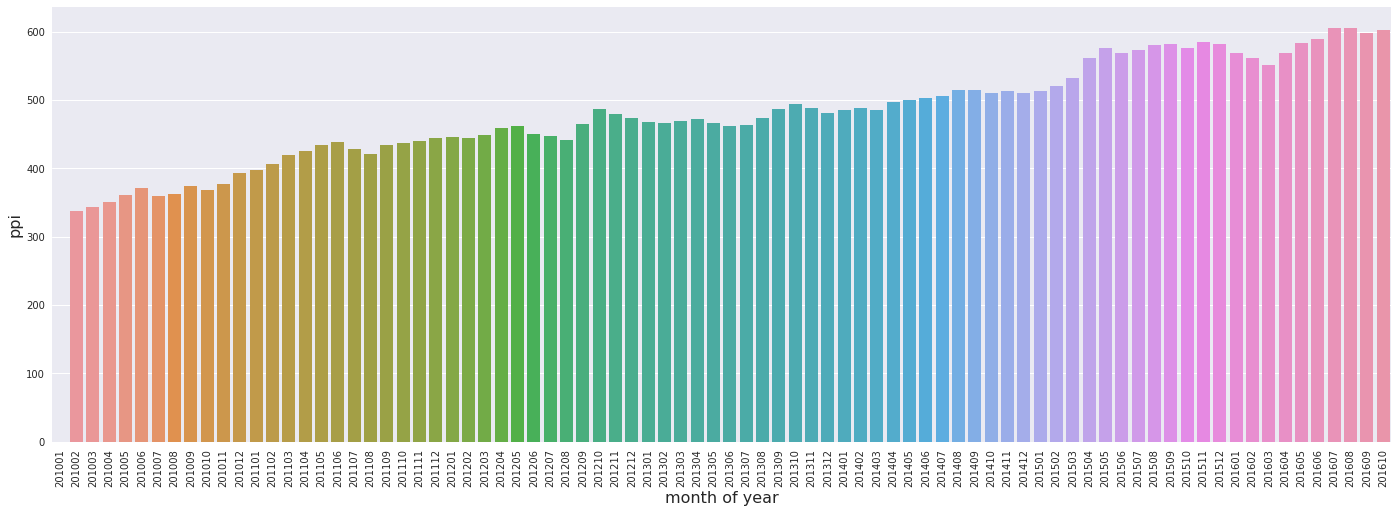

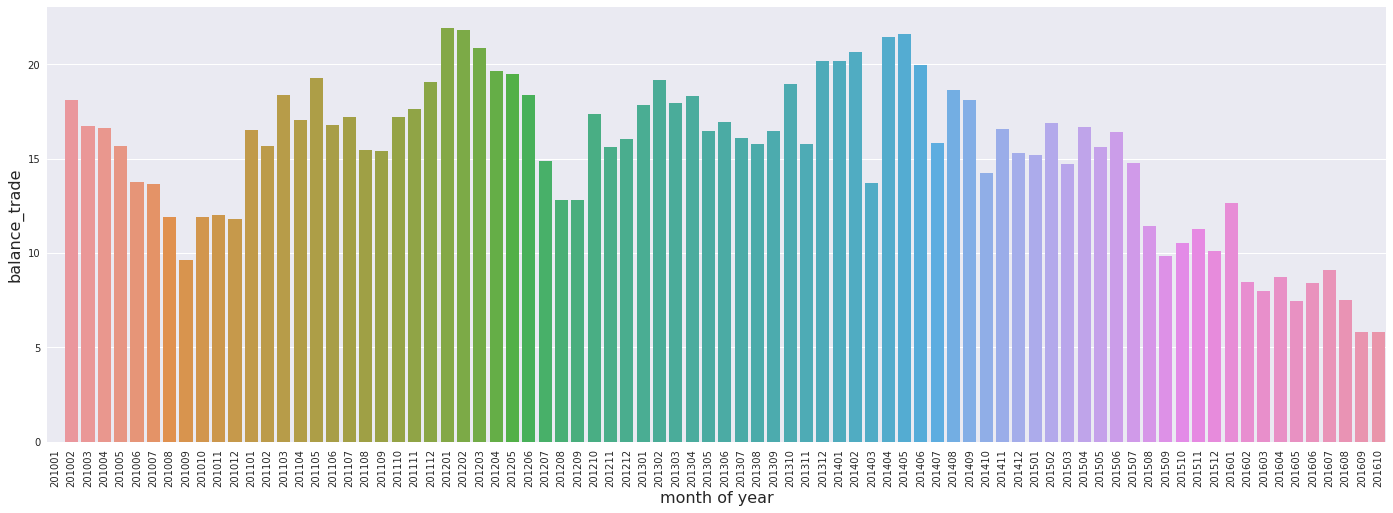

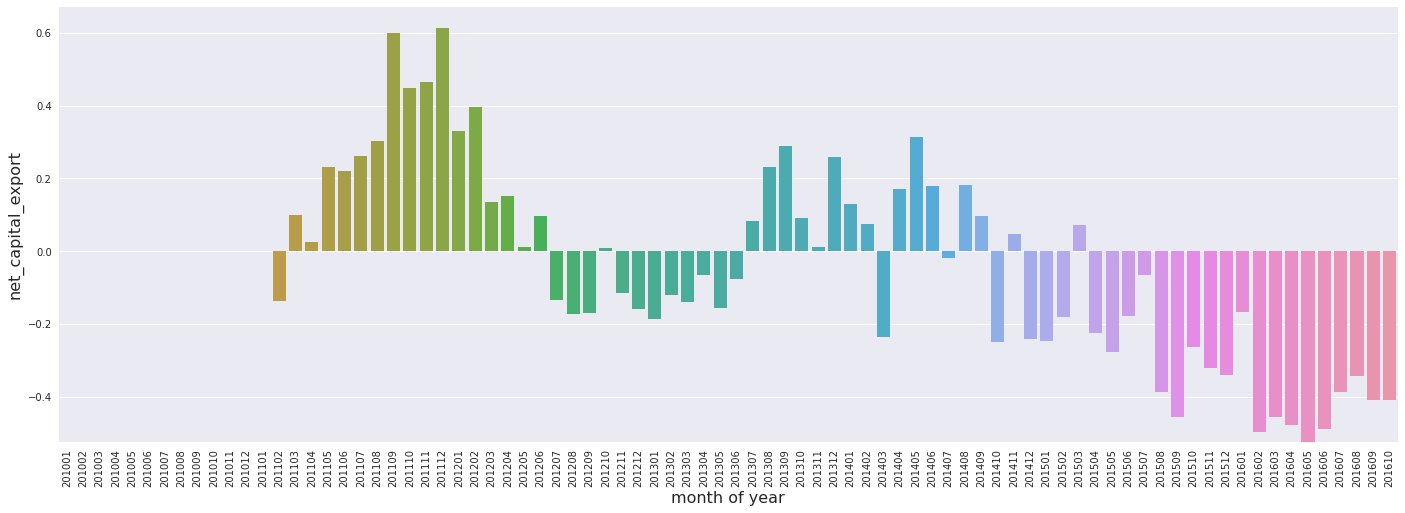

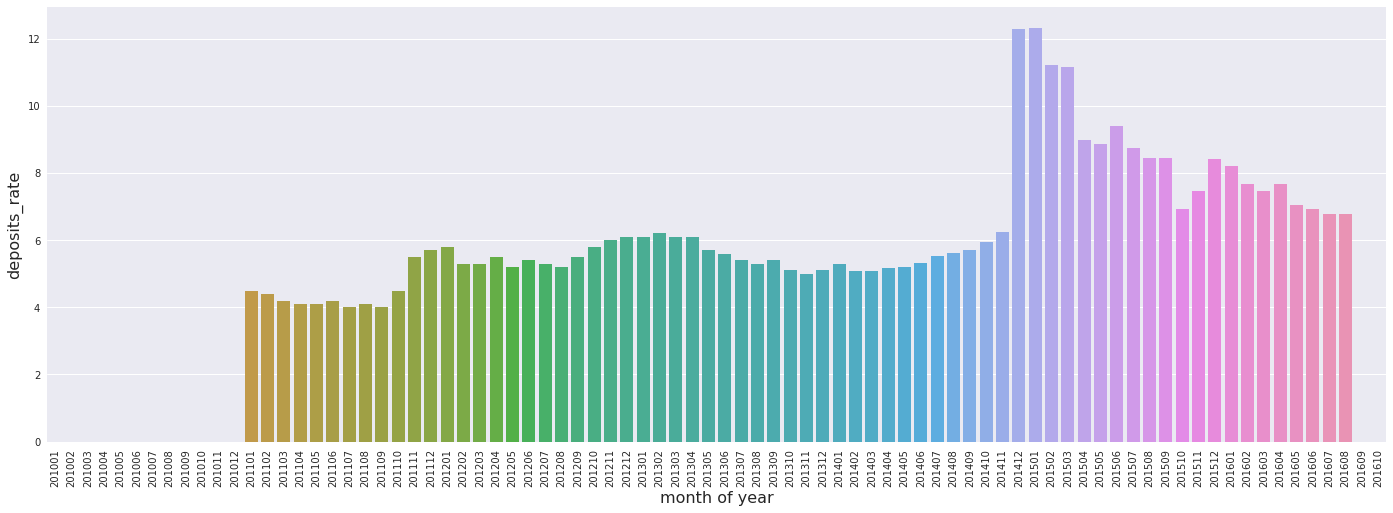

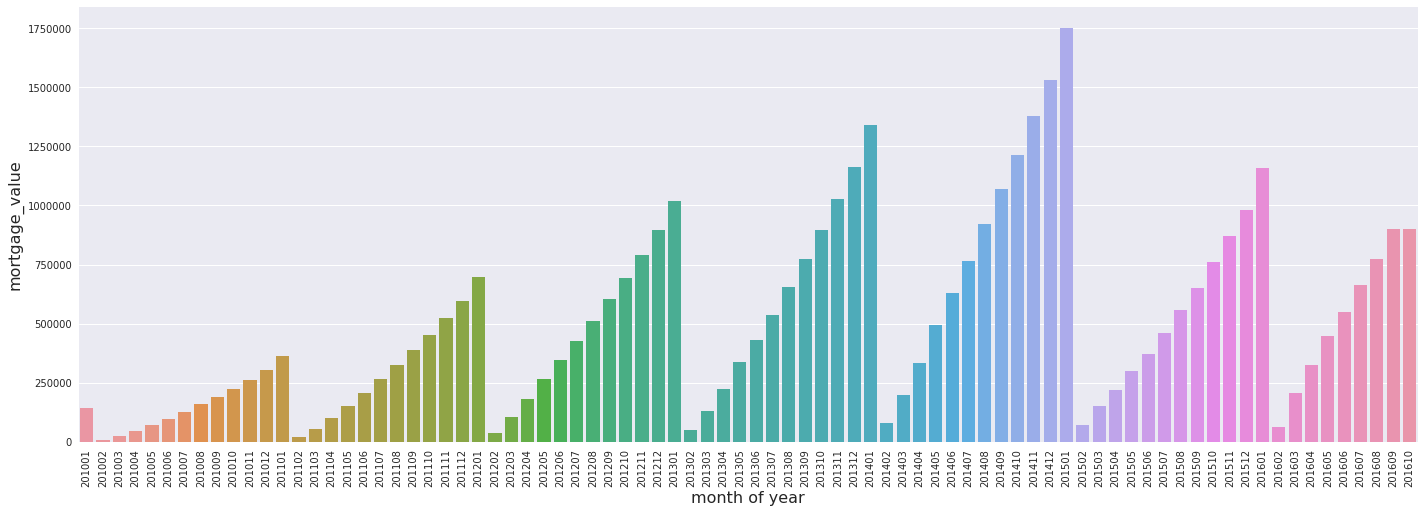

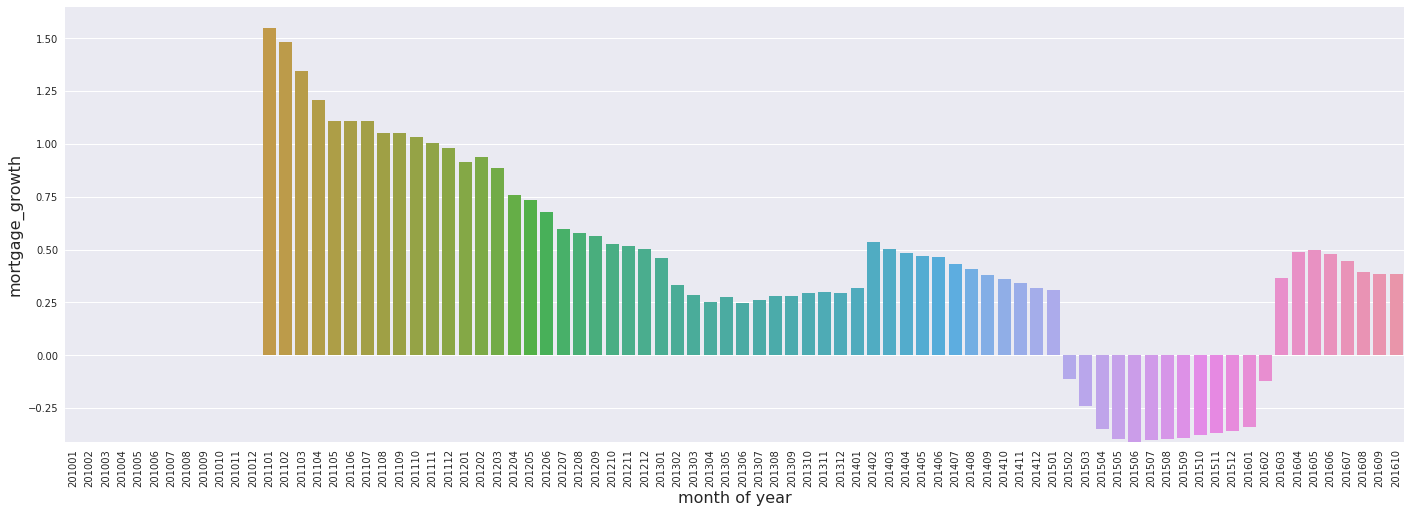

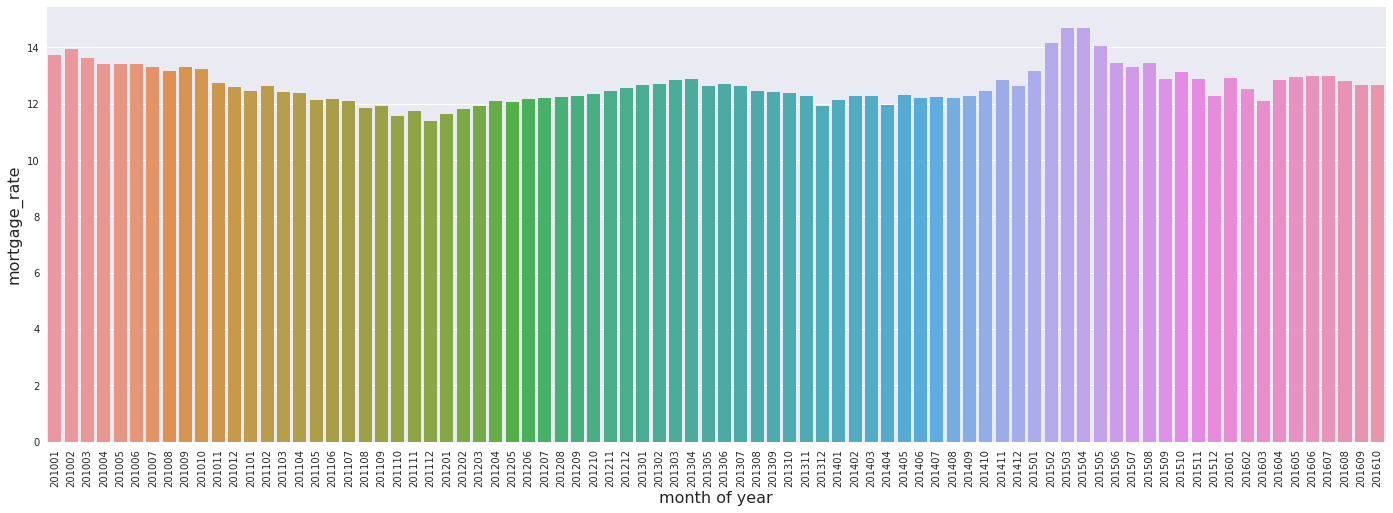

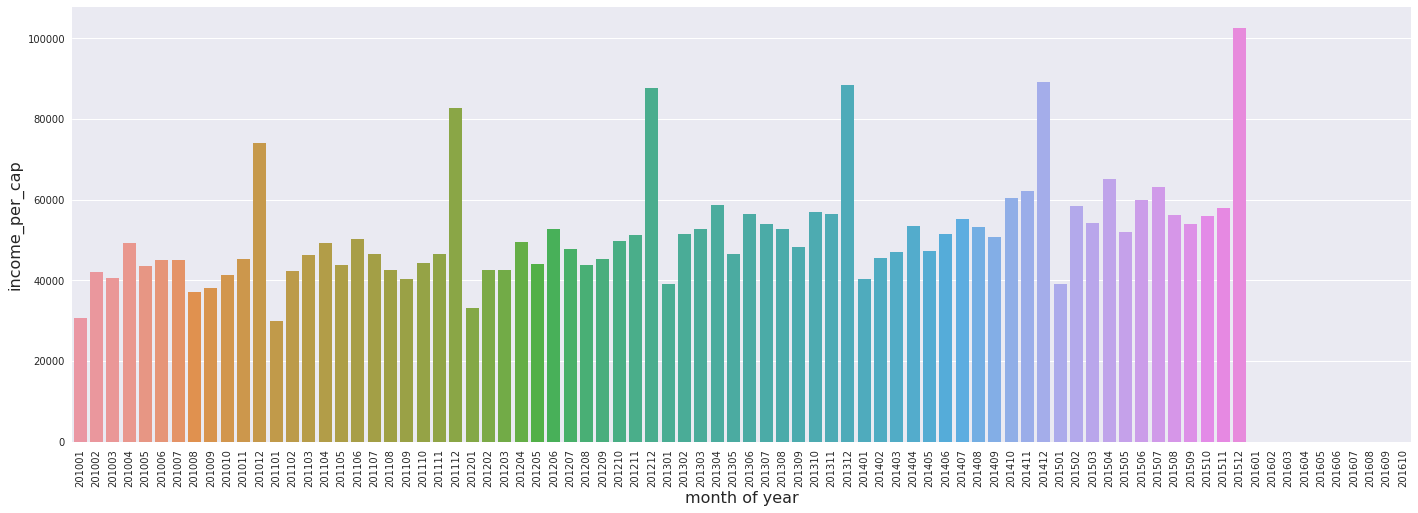

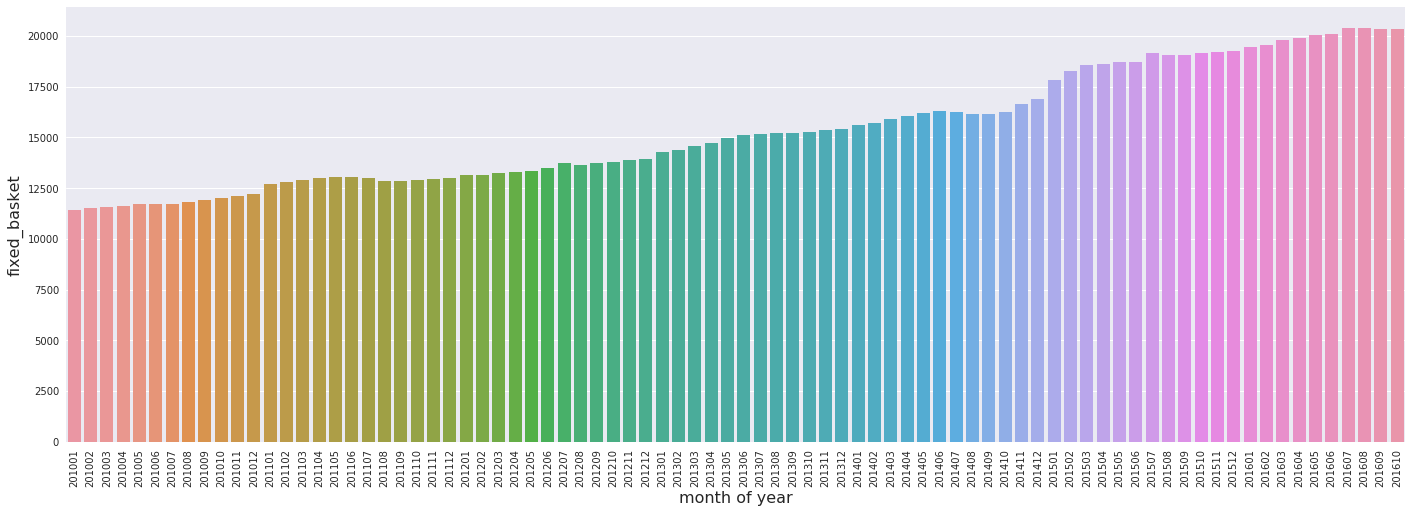

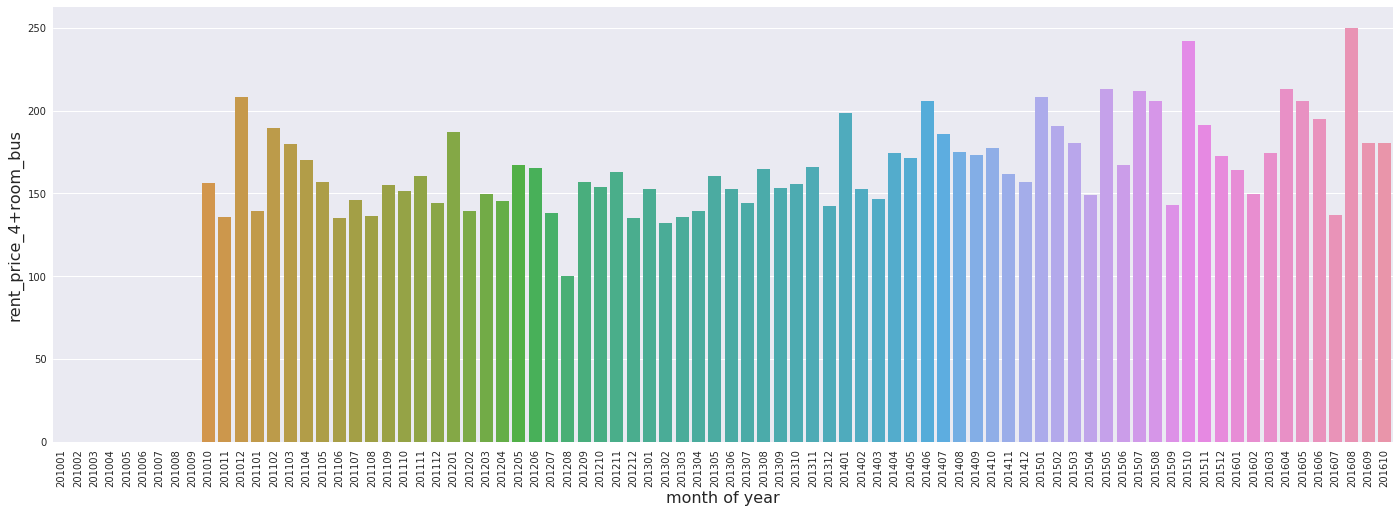

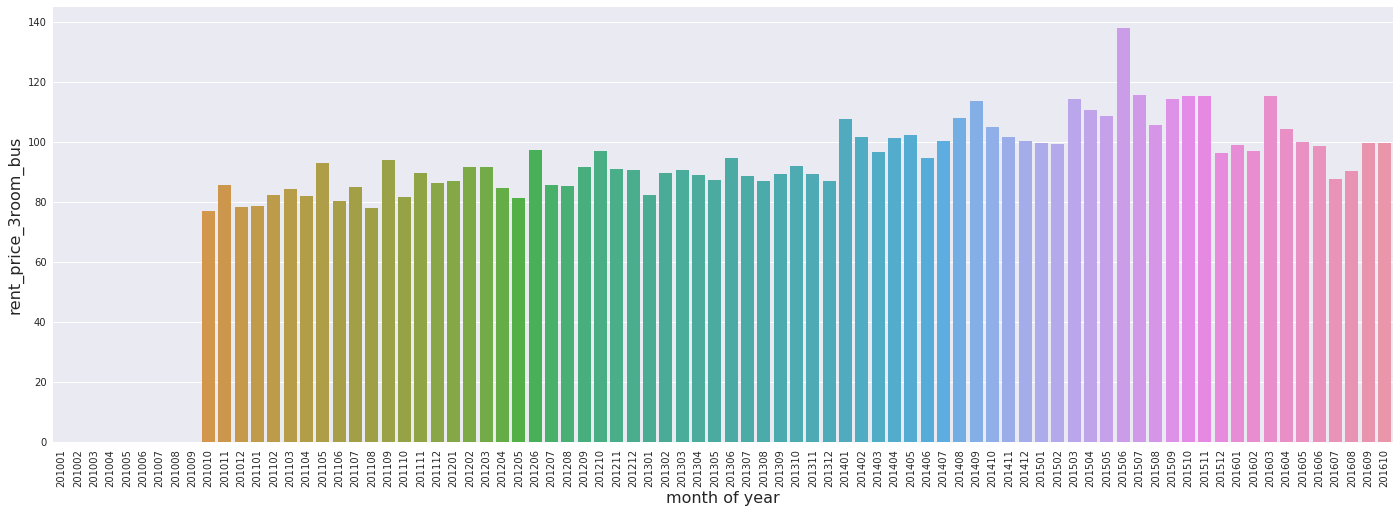

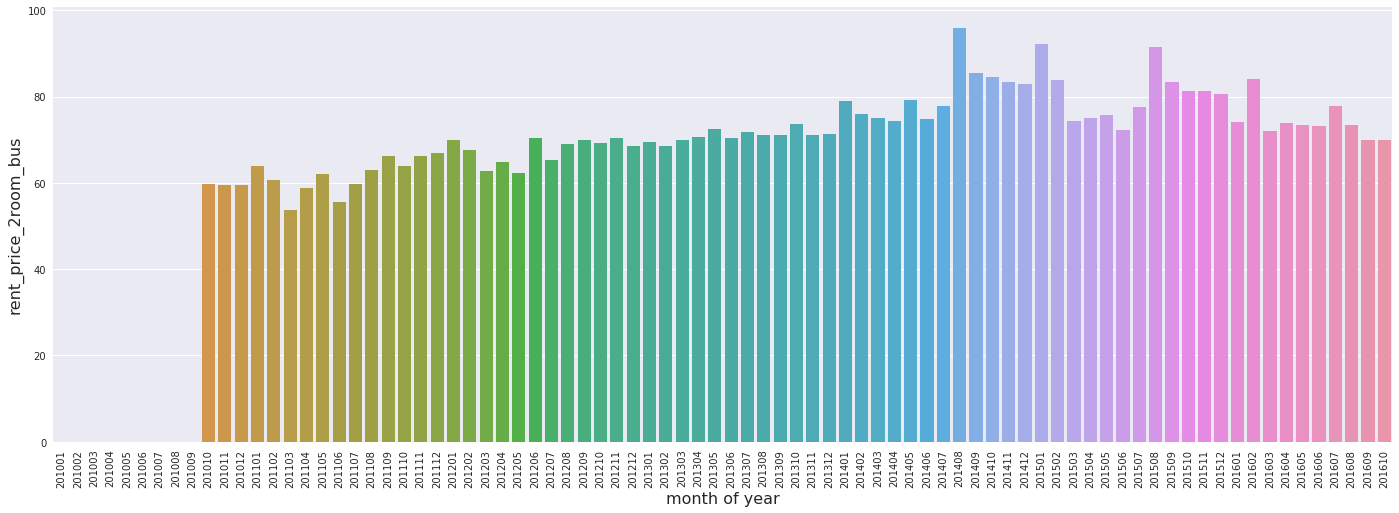

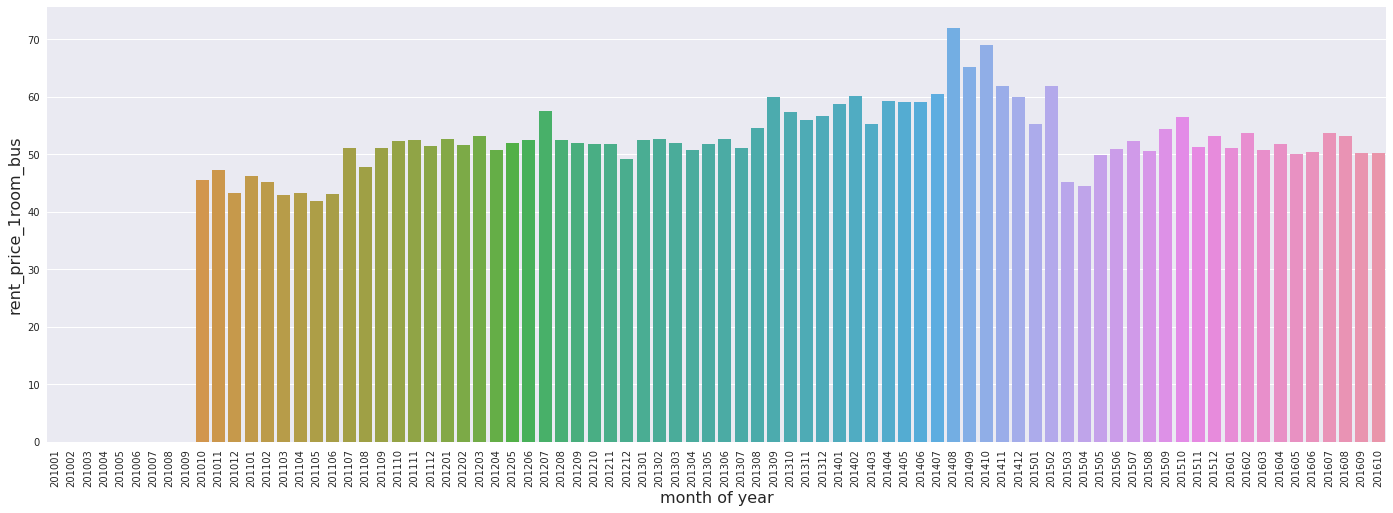

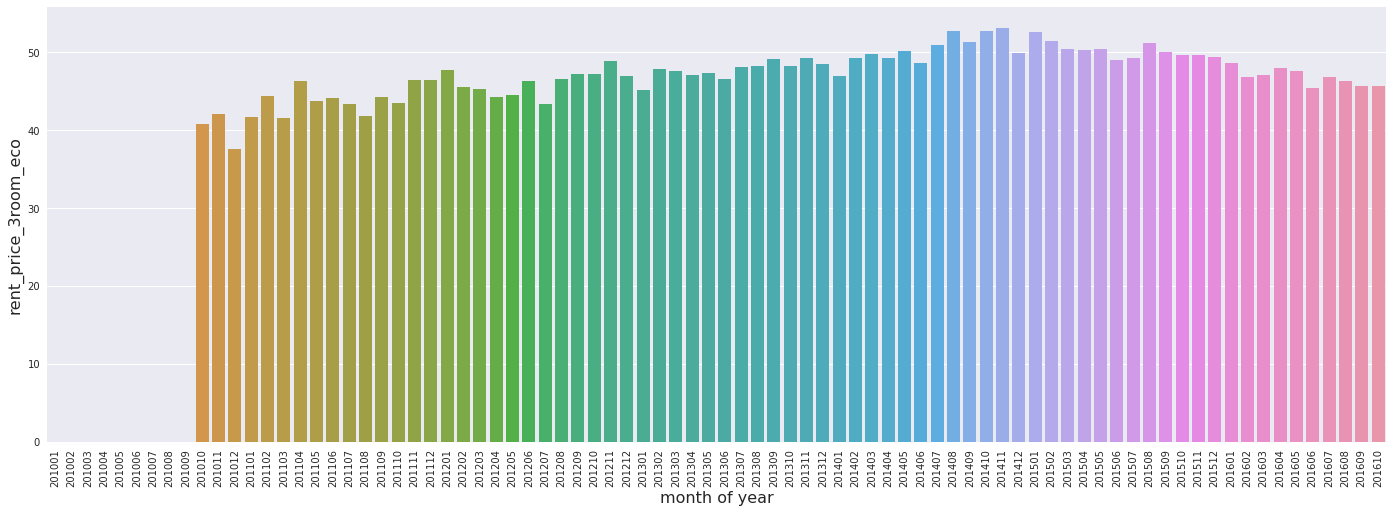

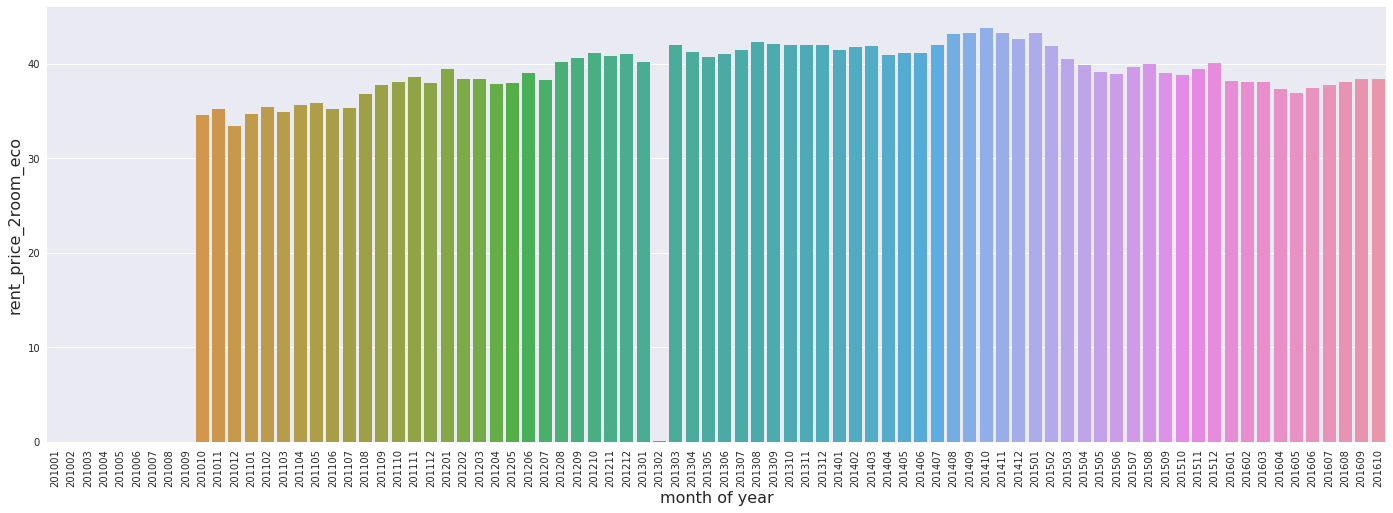

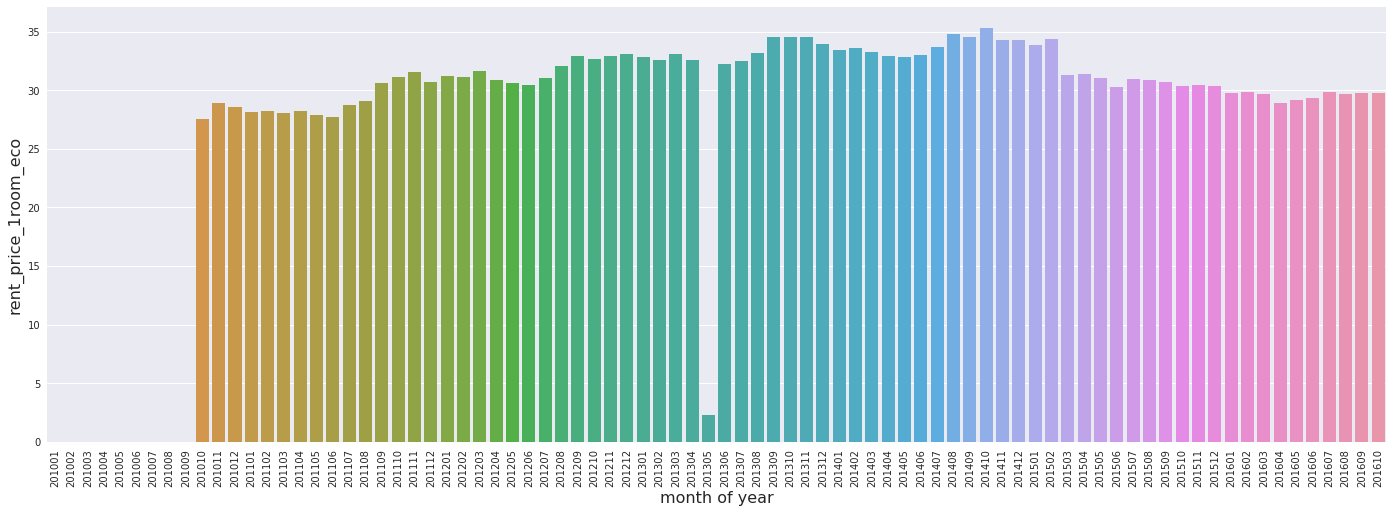

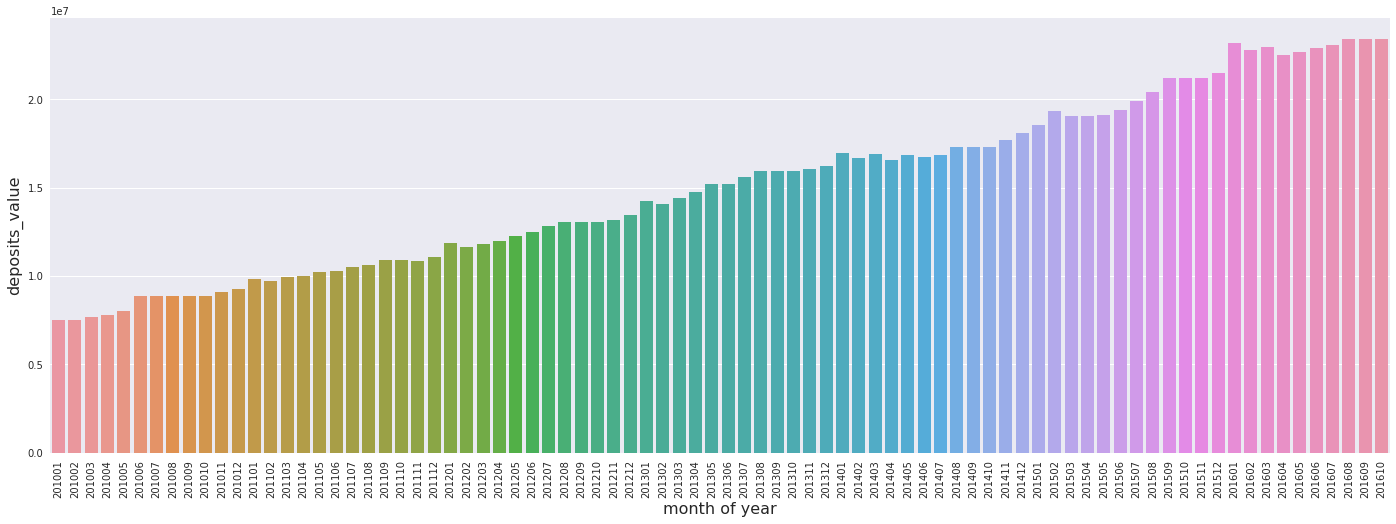

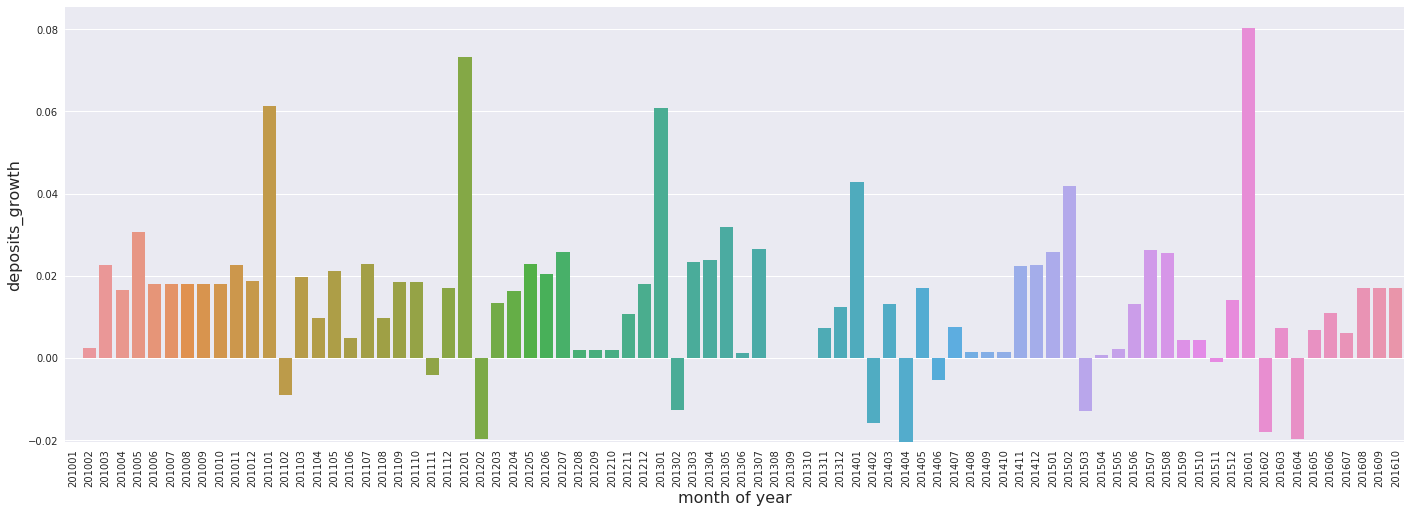

In [10]:
df_median = df.groupby(['yearmonth']).aggregate(np.median).reset_index()
monthlycol =  df_period.index[df_period['period'] == 'monthly'].tolist() + df_period.index[df_period['period'] == 'mostly monthly'].tolist()
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.barplot(x='yearmonth', y= col, data = df_median)
    plt.xlabel('month of year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

### columns with period = 'quarterly'

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


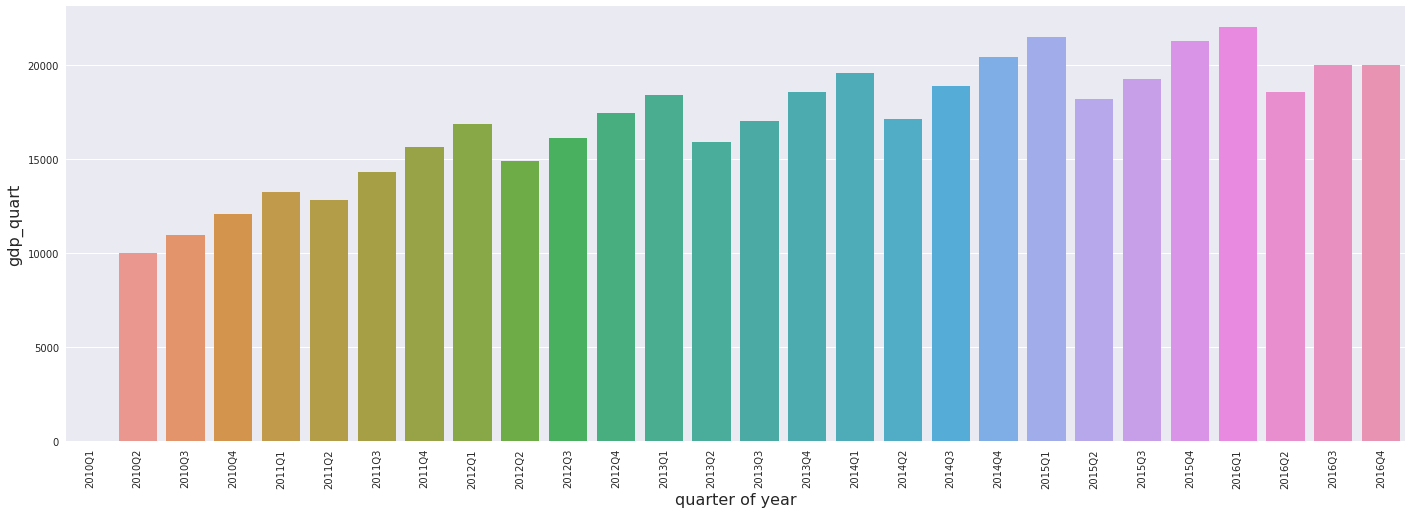

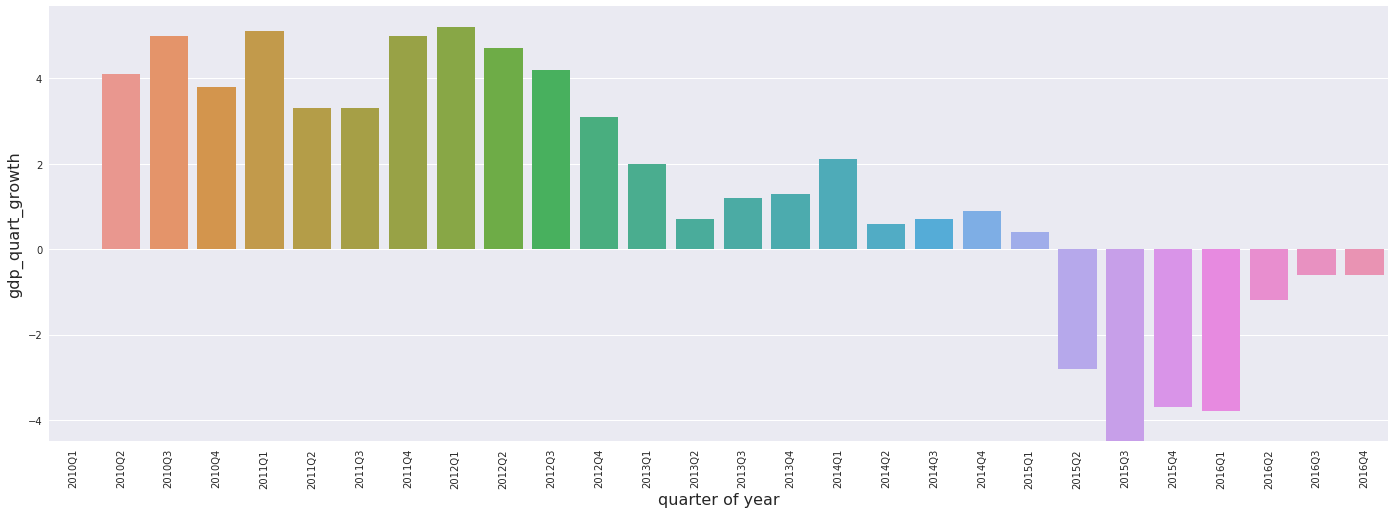

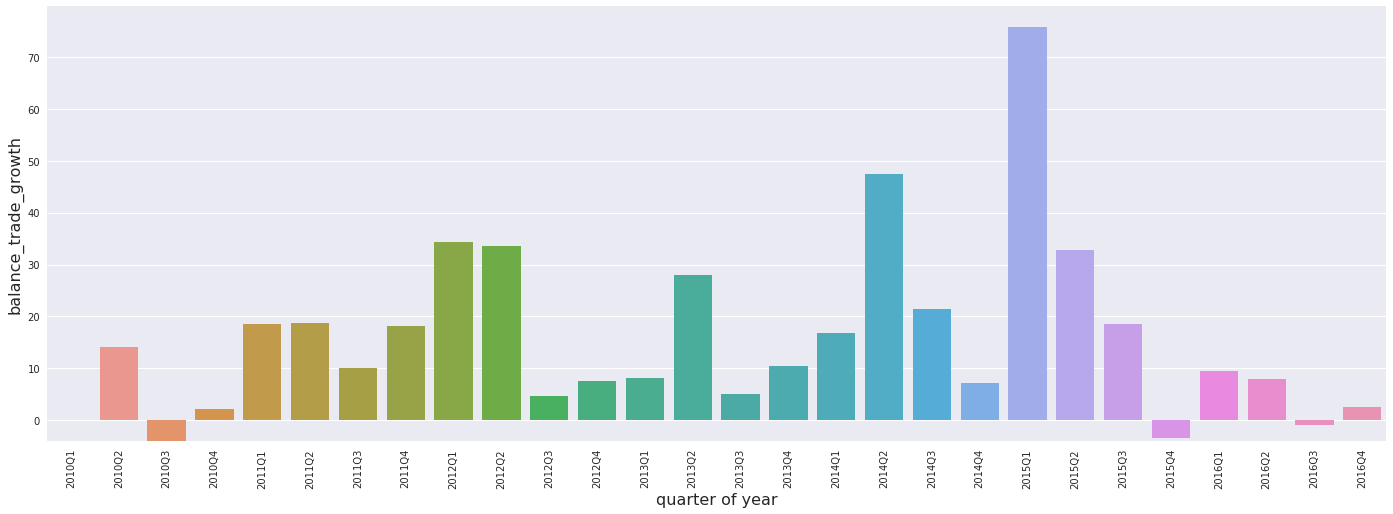

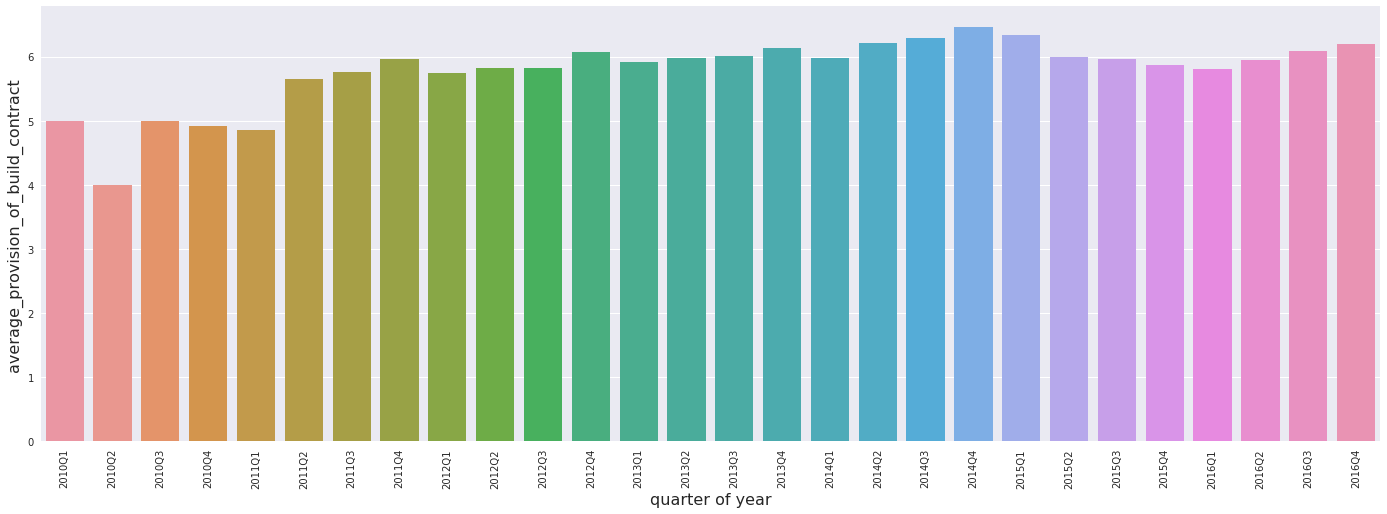

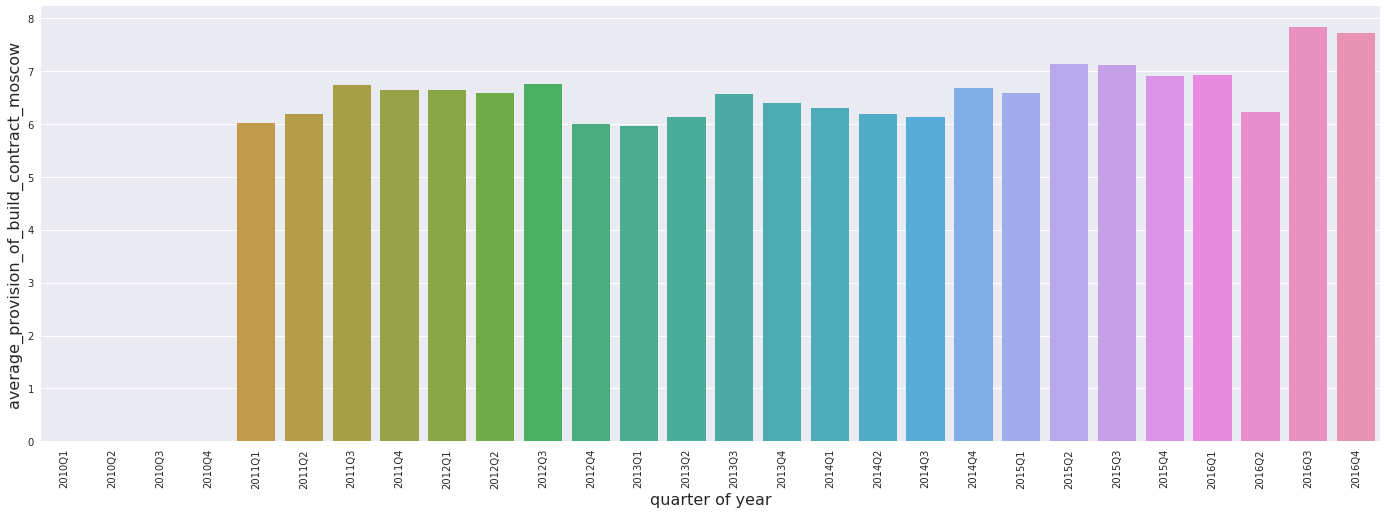

In [11]:
df_quarter = df.groupby(['yearquarter']).aggregate(np.median).reset_index()
quarterlycol =  df_period.index[df_period['period'] == 'quarterly'].tolist()
for col in quarterlycol:
    plt.figure(figsize=(24,8))
    sns.barplot(x='yearquarter', y= col, data = df_quarter)
    plt.xlabel('quarter of year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

### Columns with period = 'annual'

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


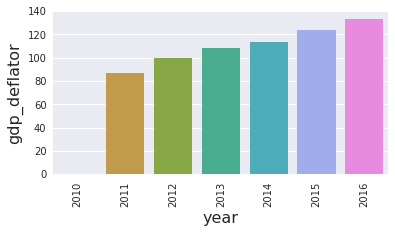

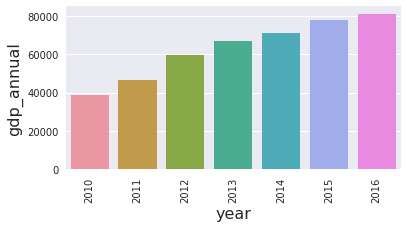

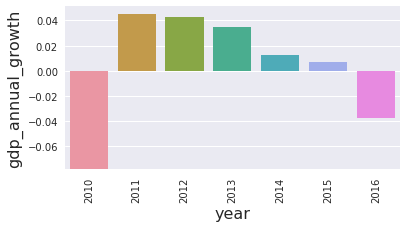

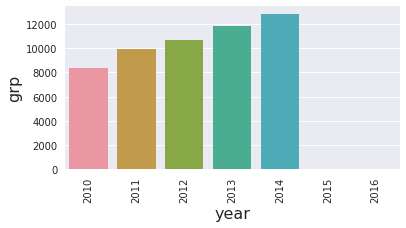

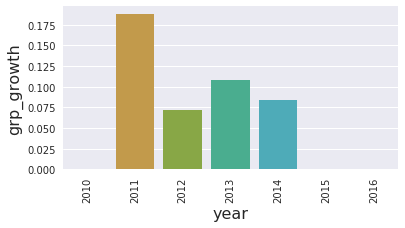

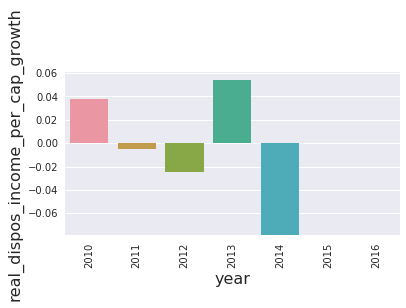

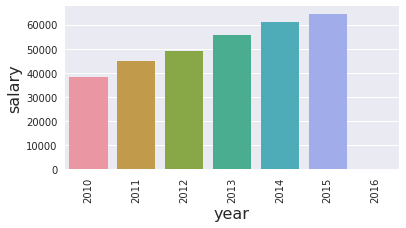

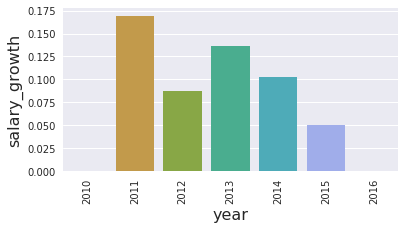

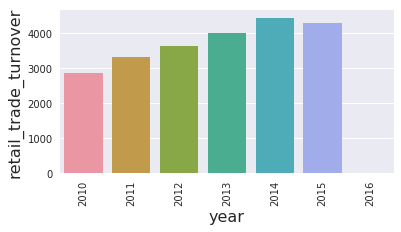

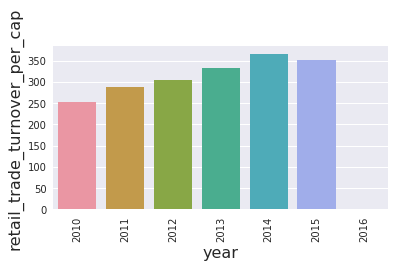

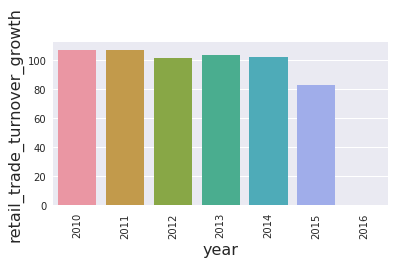

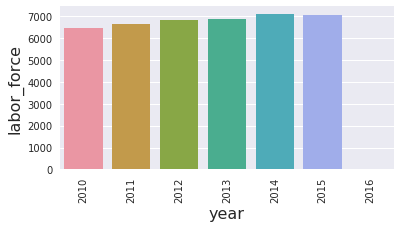

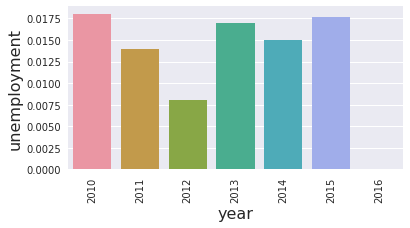

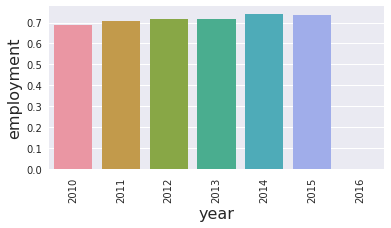

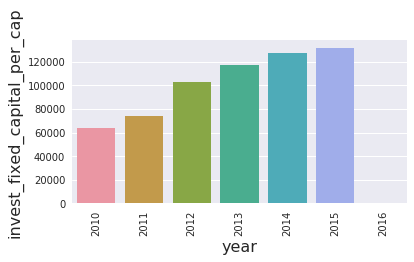

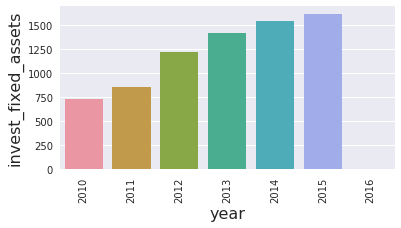

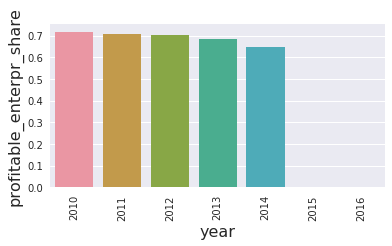

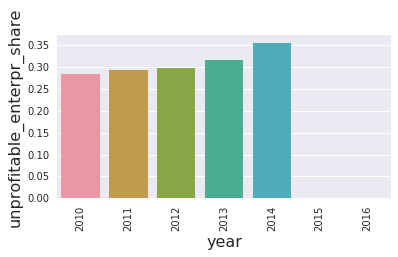

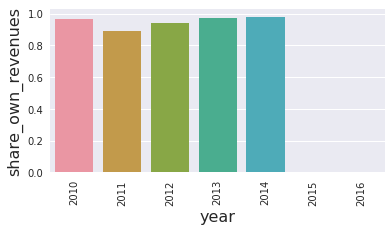

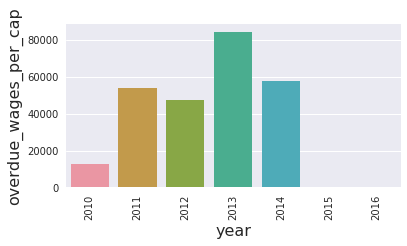

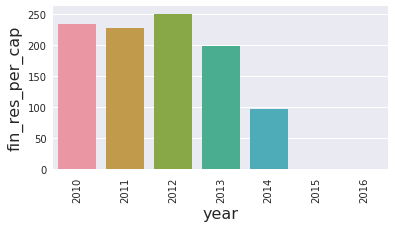

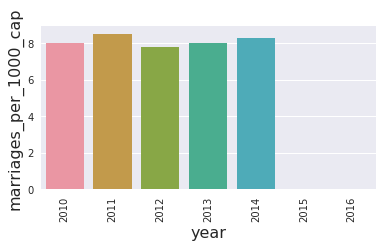

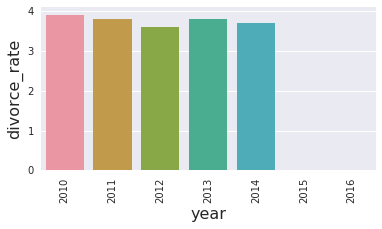

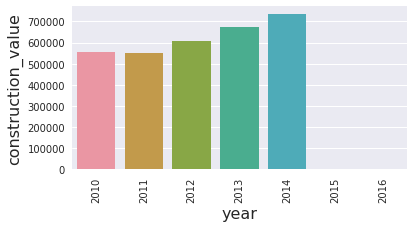

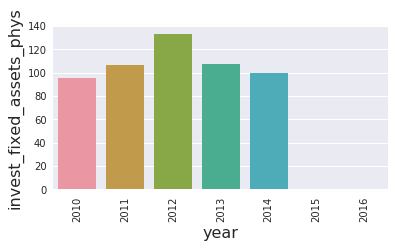

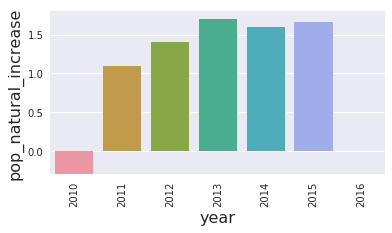

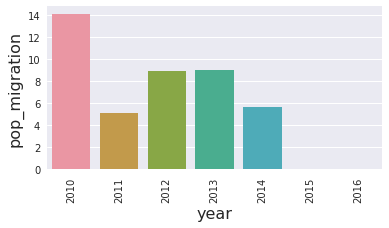

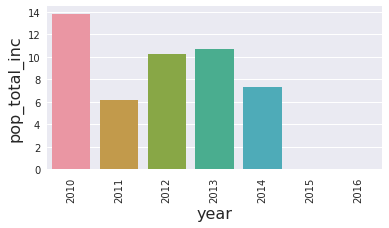

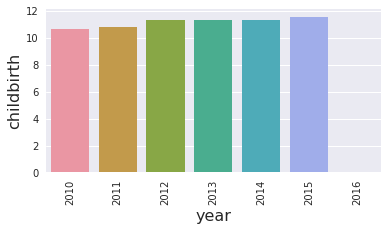

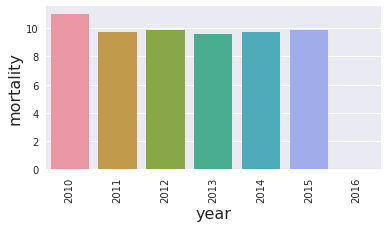

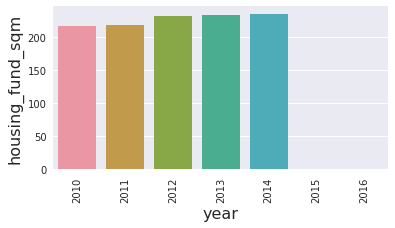

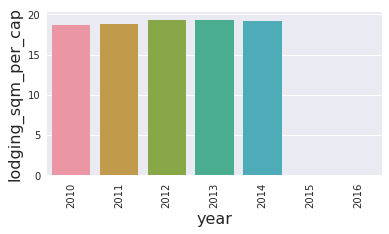

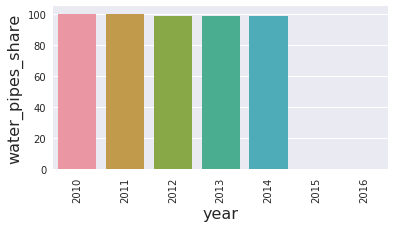

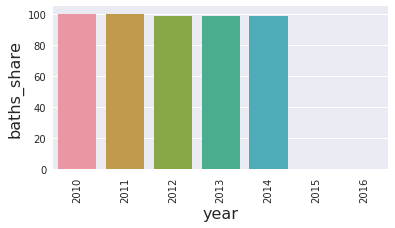

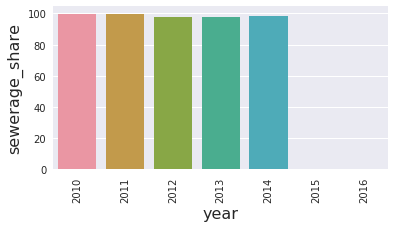

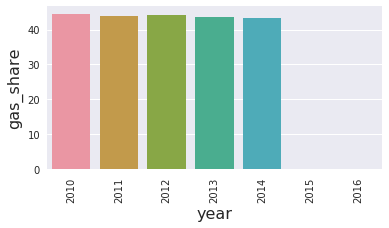

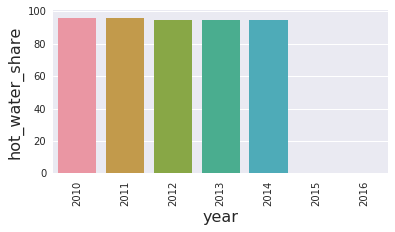

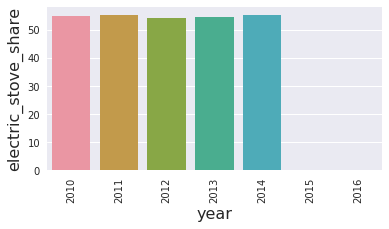

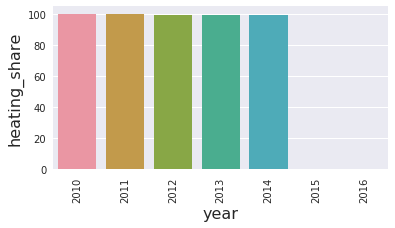

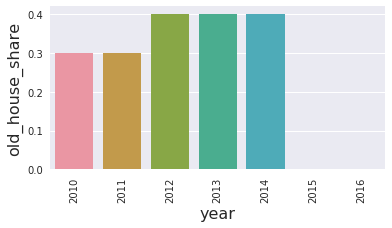

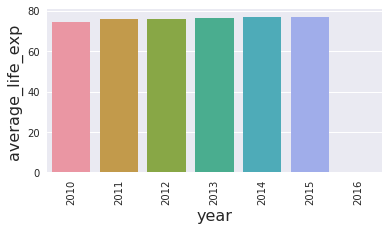

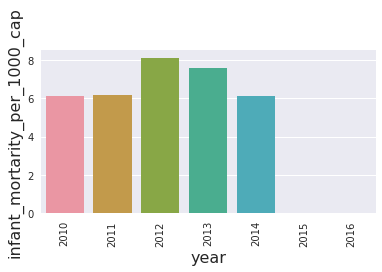

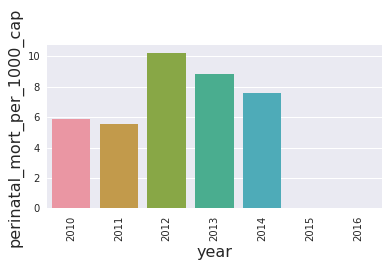

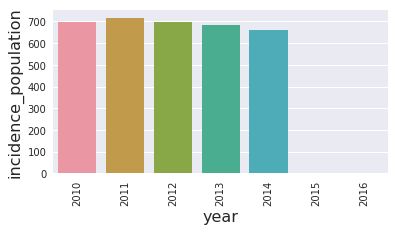

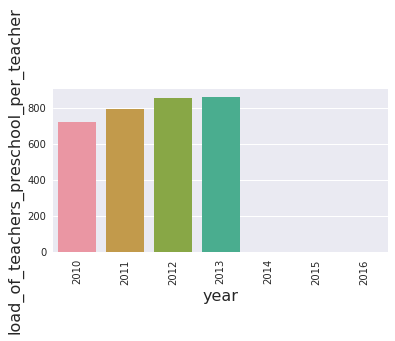

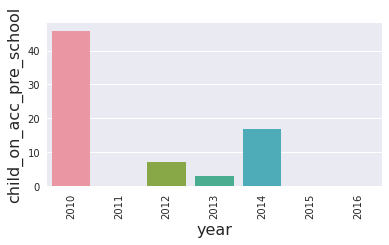

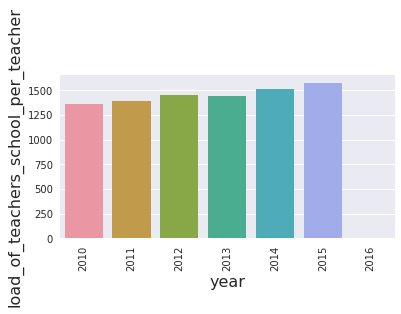

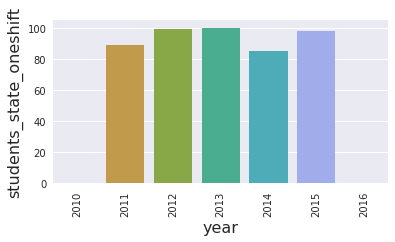

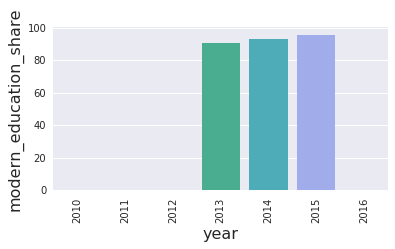

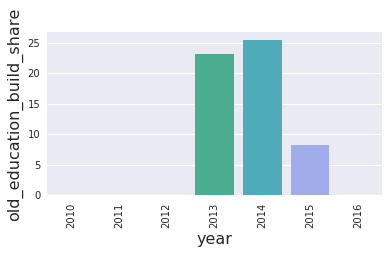

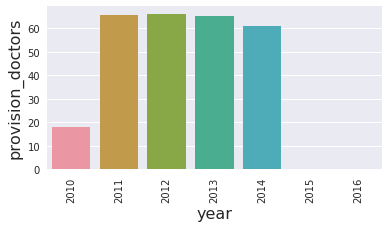

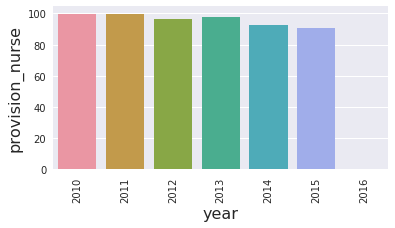

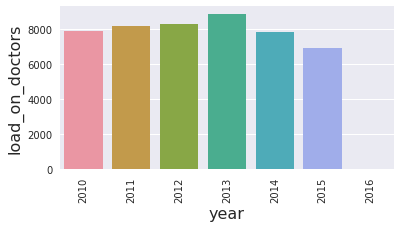

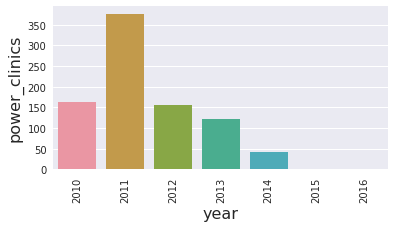

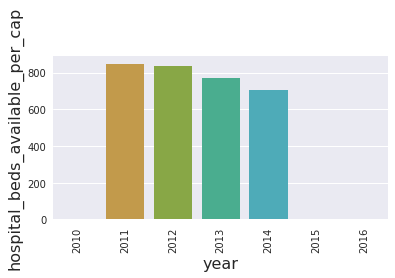

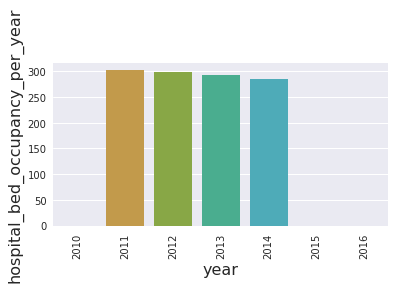

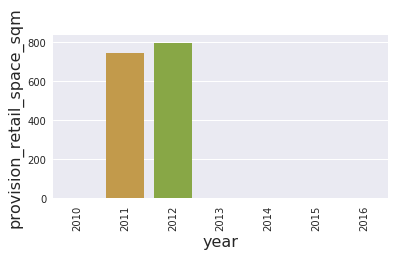

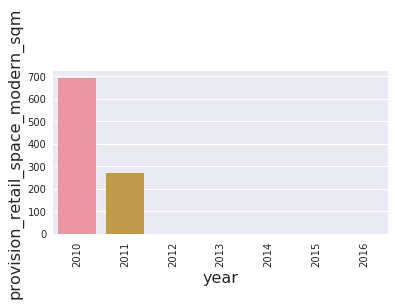

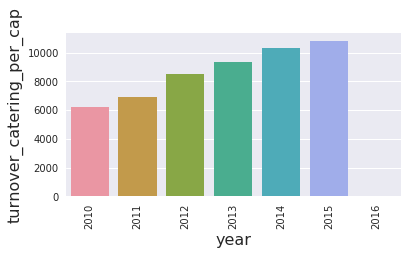

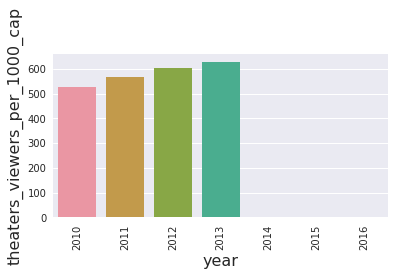

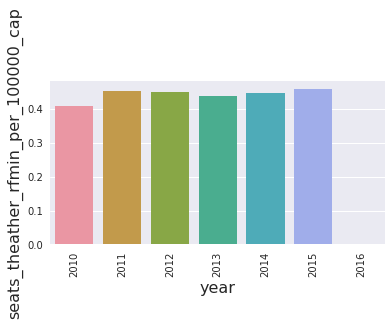

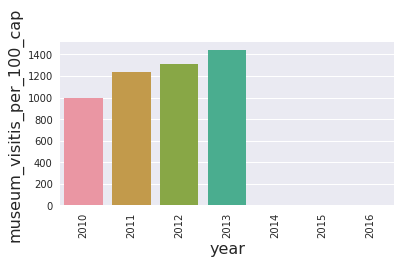

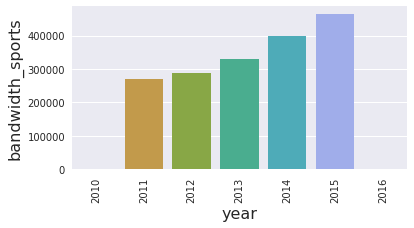

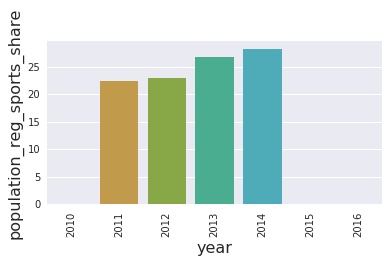

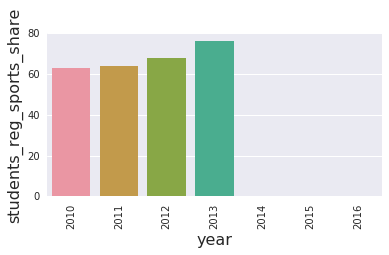

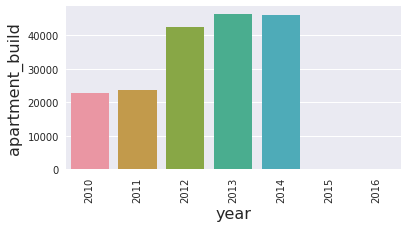

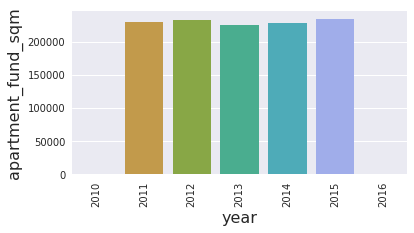

In [12]:
df_year = df.groupby(['year']).aggregate(np.median).reset_index()
annualcol =  df_period.index[df_period['period'] == 'annual'].tolist()

for col in annualcol:
    plt.figure(figsize=(6,3))
    sns.barplot(x='year', y= col, data = df_year)
    plt.xlabel('year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

# Plots with price_doc 

In [13]:
# load the price_doc in train.csv
train = pd.read_csv('/data/sberbank/train.csv')
train['yearmonth'] = train.timestamp.apply(lambda x :x[:4] +x[5:7])
train_median = train.groupby(['yearmonth']).aggregate(np.median).reset_index()

In [14]:
# merge the median of price_doc for each month to the monthly macro data
df_median = pd.merge(df_median, train_median[['yearmonth','price_doc']], on = 'yearmonth', how = 'left')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


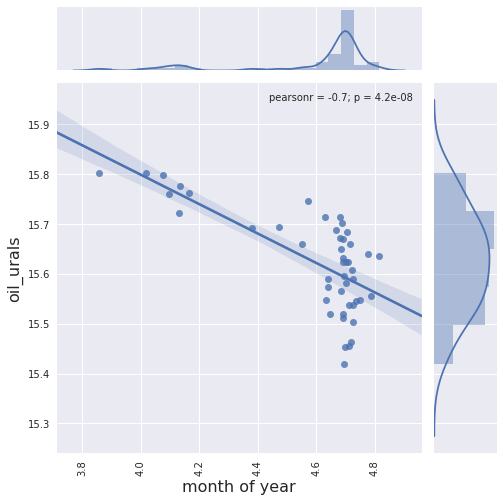

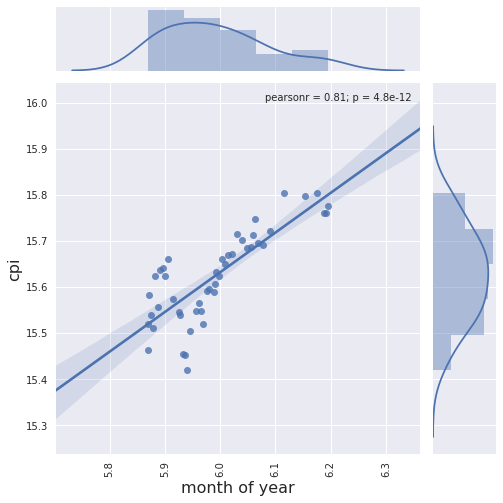

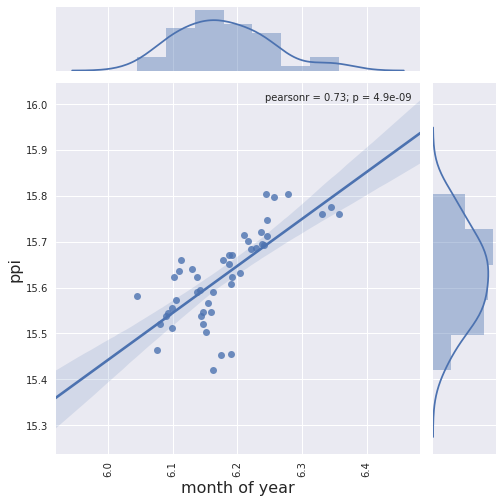

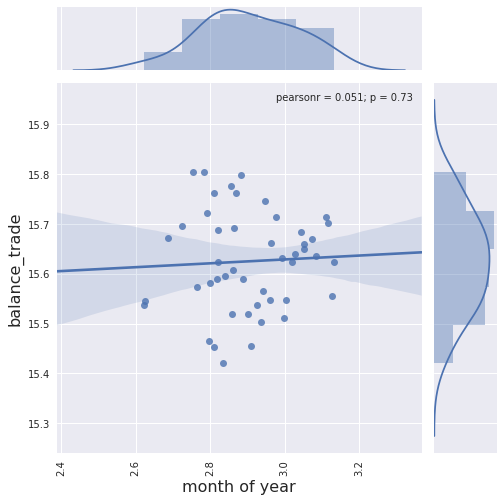

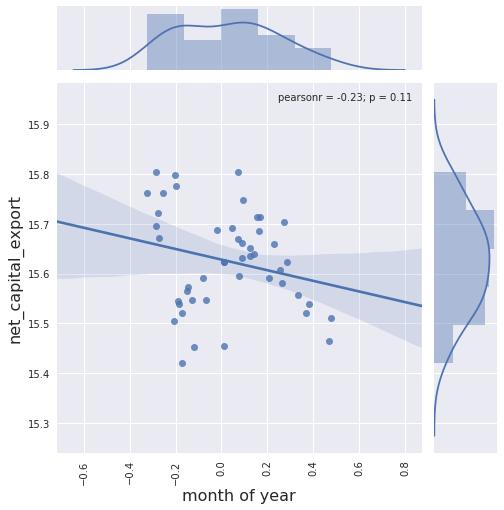

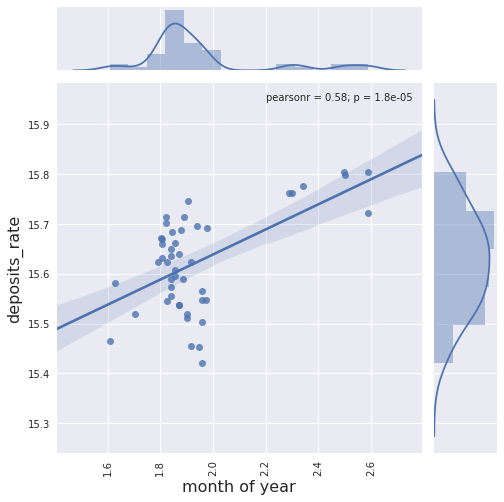

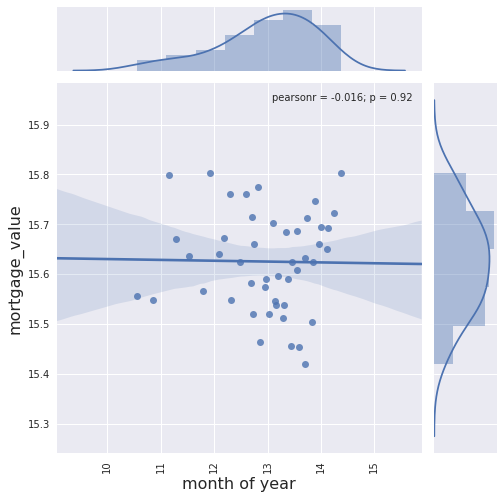

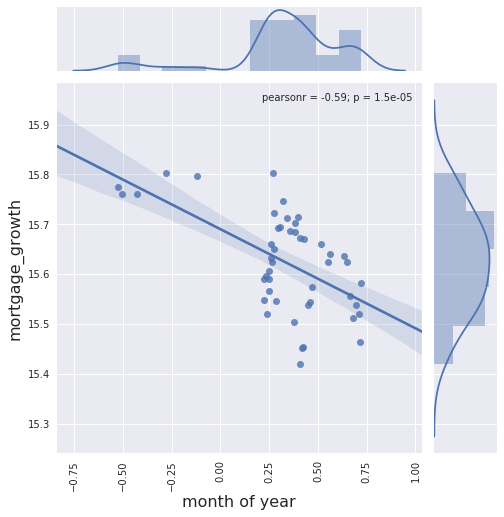

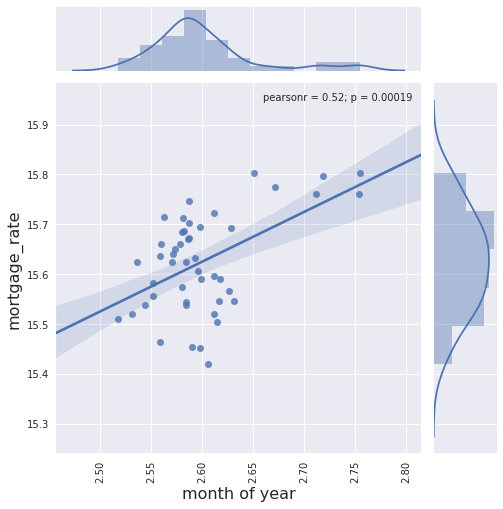

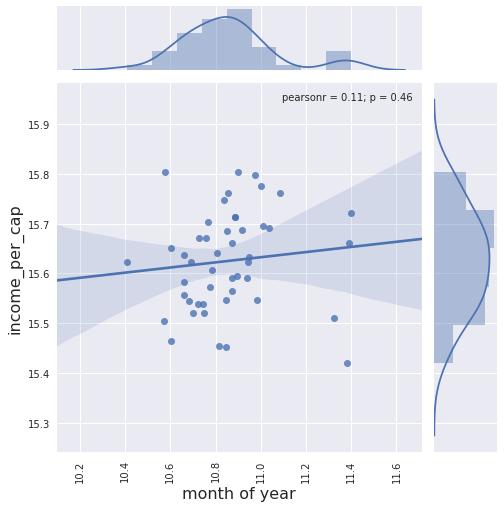

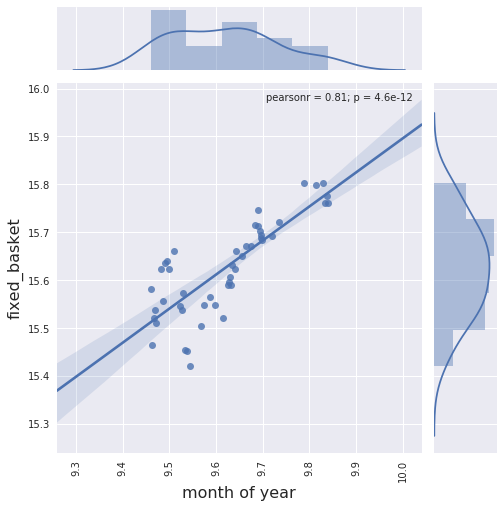

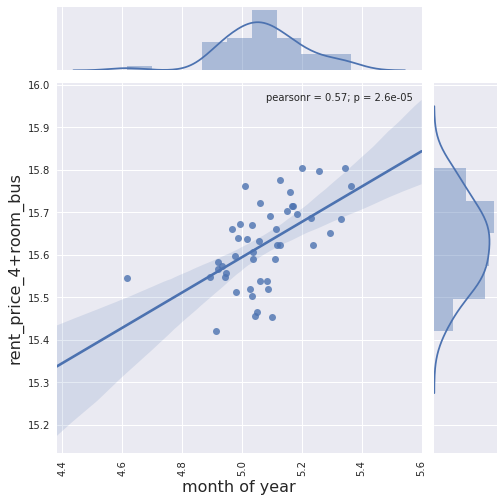

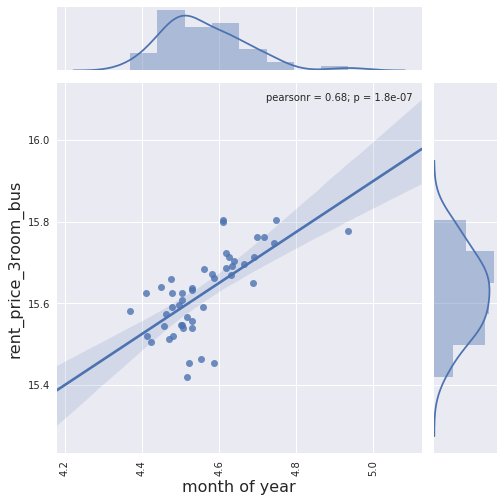

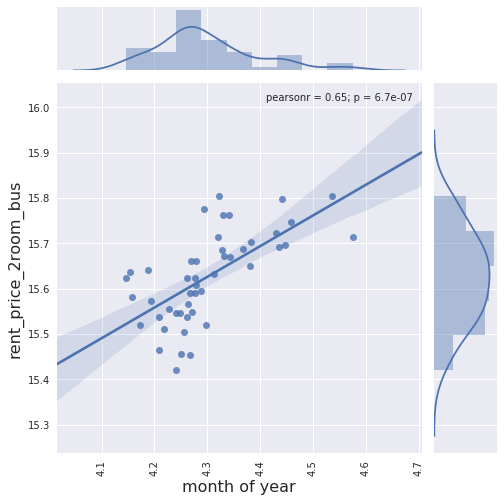

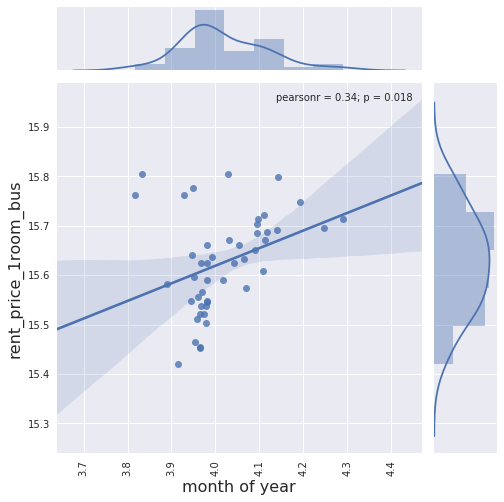

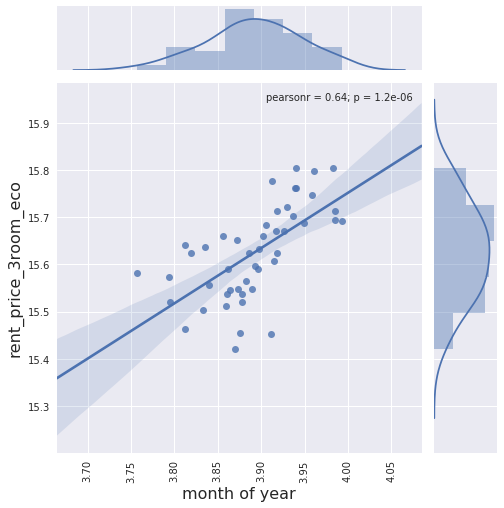

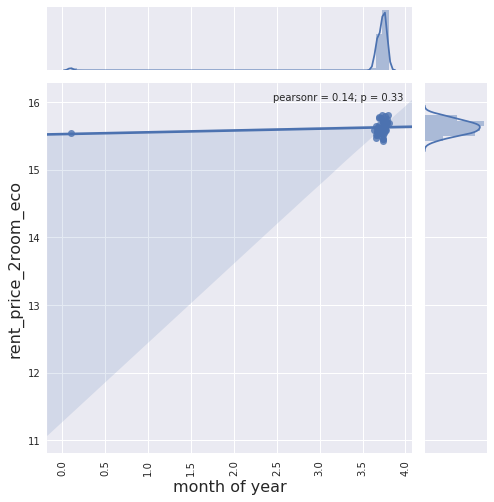

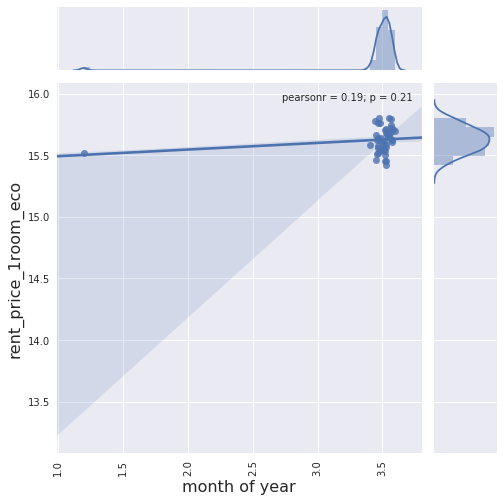

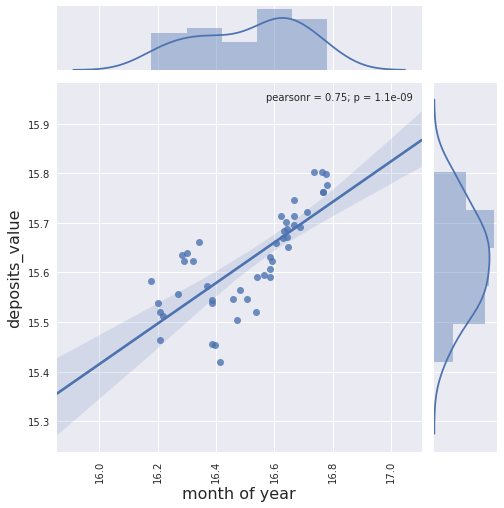

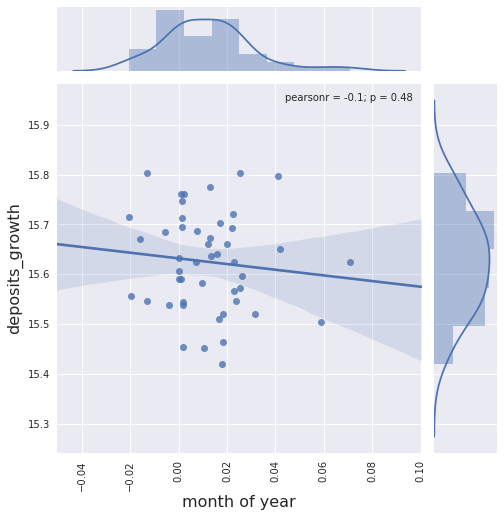

In [15]:
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.jointplot(x = np.log1p(df_median[col]), y = np.log1p(df_median.price_doc), kind="reg", size=7)
    plt.xlabel('month of year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()